#Signal/background discrimination for the VBF Higgs four lepton decay channel with the CMS experiment using Machine Learning classification techniques


**Authors:** Brunella D'Anzi, Nicola De Filippis, Domenico Diacono, Walaa Elmetenawee, Giorgia Miniello, Andre Sznajder

**Date:** March 2021, Bari, Italy





 


#Introduction to the statistical analysis problem
In this exercise, we perform a binary classification task using 2018 CMS Monte Carlo  (MC) simulated samples representing the Vector Boson Fusion (VBF) Higgs boson production in the four-lepton final state signal and its main background processes. Two Machine Learning (ML) algorithms will be implemented: an **Artificial Neural Network (ANN)** and a **Random Forest (RF)**.

**Learning Goals of the exercise**
* You will learn how a *Multivariate Analysis algorithm* works and how a Machine Learning model must be implemented;

* you will acquire basic knowledge about the *Higgs boson physics* as it is described by the Standard Model. During the exercise, you will be invited to plot some physical quantities in order to understand what is the underlying Particle Physics problem;

*  you will be invited to *change hyperparameters* of the ANN and the RF algorithms in order to understand better what are the consequences in terms of the  model performances;

*   you will understand that the choice of the *input variables* is the key to the goodness of the algorithm since an optimal choice allows achieving the best possible performances;

*   moreover, you will have the possibility of changing the background datasets, the decay channels, and seeing how the performance of the ML algorithms changes. 




###Multivariate Analysis and Machine learning algorithms: basic concepts
Multivariate Analysis algorithms receive as input a set of discriminating variables. Each variable alone does not allow to reach an optimal discrimination power between two categories (signal and background). Therefore the algorithms compute an output that combines the input variables. 

This is what every **Multivariate Analysis (MVA) discriminator** does. The discriminant output, also called *discriminator, score , or classifier*, is used as a test statistic and is then adopted to perform the signal selection. It could be used as a variable on which a cut can be applied under a particular hypothesis test.

In particular, Machine Learning tools are models which have enough capacity to define their own internal representation of data to accomplish two main tasks : *learning from data* and make predictions without being explicitly programmed to do so. 

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/fbb053597adf9e950d7c7ccef4b72797d0a22f9d/Hypothesis_testing.png" style="display: center; margin: auto;" width="500" align="right"  /><br>
In the case of binary classification, firstly the algorithm is *trained* with two datasets: 
* one that contains events distributed according to **the null** (in our case **signal** - there exist other conventions in actual physics analyses) **hypothesis $H_{0}$** ;
* another one according to the **alternative** (in our case **background**) **hypothesis $H_{1}$** .

Then the algorithm must learn how to classify new datasets (the test dataset in our case). 
<br><br>
This means that we have the same set of features (random variables) with their own distribution on the $H_{0}$ and $H_{1}$ hypotheses.
<br>
To obtain a good ML classifier with high discriminating power, we will follow the following steps: 

* **Training (learning)**: a discriminator is built by using all the input variables. Then, the
parameters are iteratively modified by comparing the discriminant output to the true label of the dataset (*supervised machine learning algorithms*,we will use two of them). This phase is crucial: one should tune the input variables and the parameters of the algorithm!
  * As an alternative, algorithms that group and find patterns in the data according to the observed distribution of the input data are called *unsupervised learning*.
  * A good habit is training multiple models with various hyperparameters on a “reduced” training set ( i.e. the full training set minus the so-called **validation set**), and then select the model that performs best on the validation set.
  * Once, the validation process is over, you can re-train the best
model on the full training set (including the validation set), and this
gives you the final model.

* **Test**: once the training has been performed, the discriminator score is computed in a *separated, independent dataset*  for both $H_{0}$ and $H_{1}$.
* A comparison is made between test and training classifier and their performances (in terms of ROC curves) are evaluated.
 * If the test fails and the performance of the test and training are different, this could be a symptom of **overtraining** and our model can be considered not good!





## Uploading Files

The following is a technical part that you can completely skip if you are not interested in how to upload ROOT files on a Google Colab's notebook like this. Beware: you will use a Software as Services (SAS) from [Cloud@ReCaS-Bari](https://www.recas-bari.it/index.php/it/recas-bari-i-servizi-it/recas-bari-i-servizi/cloud-recas-software-as-a-service).


In [1]:
#This is selecting the full dataset, it will take a while (2-3 minutes). 
#Comment afterwards, no need to re-run this box!

!pip install uproot

files = { #time for uploading = almost 3 minutes
    "VBF_HToZZTo4mu.root" : "PCH8ZgVPVwgtqXF", #signal events| 4-muons channel
    "GluGluHToZZTo4mu.root": "64ngyPZosPKsp3Q", #1st background events| 4-muons ch
    "ZZTo4mu.root"       : "JUzjDb5tjy6tZpC", # 2nd background| 4-muons
    #"ttH_HToZZ_4mu.root"   :"RzS4CXKExWijjfQ", 3nd background | 4-muons
    #"VBF_HToZZTo4e.root": "dBdaKwA13bygU8c", # alternative signal| 4e-channel
    #"GluGluHToZZTo4e.root": "2DxFLqLtjkbWFdM", #alternative background| 4e-ch
    #"ZZTo4e.root"     : "NhAutemXTrVunU0", #alternative background| 4e-ch
     #"ttH_HToZZ_4e.root" :   "DRDeVWSSZzJNduw" #alternative background| 4e-ch
    }
!rm -f *.root
import os 
for file in files.items():
  if not os.path.exists(file[0]):
    b = os.system ( "wget -O %s --no-check-certificate 'https://recascloud.ba.infn.it/index.php/s/%s/download'" % file )
    if b: raise IOError ( "Error in downloading the file %s : (%s)" % file )

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


#Introduction to the physics problem
In this section you will find the following subsections:
* **Particle Physics basic concepts: the Standard Model and the Higgs boson**<br>
you may skip it you have already basics knowledge about Particle Physics (cross-section,decay channels,Standard Model definitions, etc.).
* **Data exploration:** <br>it is important that you pay attention to this section in order to understand all the next steps of the exercise.


## Particle Physics basic concepts: the Standard Model and the Higgs boson


If everything went well until now, let's have a look at the physics we are interested in!


<br>
<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/SM.png" width="400" align="left">

 The **Standard Model** of elementary particles represents our knowledge of the microscopic world. It describes the matter constituents (quarks and leptons)  and their interactions (mediated by bosons), which are the electromagnetic, the weak, and the strong interactions.


 Among all these particles, the **Higgs boson** still represents a very peculiar case. It is the second heaviest known elementary particle (mass of 125 GeV) after the top quark (175 GeV).

 The ideal instrument for measuring the Higgs boson properties is a particle collider. The **Large Hadron Collider** (LHC), situated nearby Geneva, between France and Switzerland, is the largest proton-proton collider ever built on Earth. It consists of a 27 km circumference ring, where proton beams are smashed at a center-of-mass energy of 13 TeV (99.999999% of the speed of light). At the LHC, 40 Million collisions / second occurs, providing an enormous amount of data. Thanks to these data, **ATLAS** and **CMS** experiments discovered the missing piece of the Standard Model, the Higgs boson, in 2012.

 During a collision, the energy is so high that protons are "broken" into their fundamental components, i.e. **quarks** and **gluons**, which can interact together, producing particles that we don't observe in our everyday life, such as the top quark. The production of a top quark is, by the way, a relatively "rare" phenomenon, since there are other physical processes that occur more often, such as those initiated by strong interaction, producing lighter quarks (such as up, down, strange quarks). In high-energy physics, we speak about the **cross-section** of a process. We say that the top quark production has a smaller cross-section than one of the productions of light quarks.

 The experimental consequence is that distinguishing the decay products of a top quark from a light quark can be extremely difficult, due to the quite larger probability to occur of the latter phenomenon.
### Experimental signature of Higgs boson in a particle detector

Let's first understand what are the experimental signatures and how the detectors work at the LHC experiment. As an example, this is a sketch of the Compact Muon Solenoid (CMS) detector.

<br>
<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/EPS_CMS_Slice.png" width="800" >

A collider detector is organized in layers: each layer is able to distinguish and measure different particles and their properties. For example, the silicon tracker detects each particle that is charged. The electromagnetic calorimeter detects photons and electrons. The hadronic calorimeter detects hadrons (such as protons and neutrons). The muon chambers detect muons (that have a long lifetime and travel through the inner layers).

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-09%20alle%2023.42.06.png" width="200" height="200" style="display:center; margin: auto;" align="left">

Our physics problem consists in detecting the so-called **“golden decay channel”  $H \to ZZ^{*} \to l^{+}l^{-}l'^{+}l'^{-}$**  which is one of the possible Higgs boson's decays: its name is due to the fact that it has the clearest and cleanest signature of all the possible Higgs boson's decay modes. The decay chain is sketched here: the Higgs boson decays into Z boson pairs, which in turn decay into a lepton pair (in the picture, muon-antimuon or electron-positron pairs). In this exercise, we will use only datasets concerning the **$4\mu$ decay channel** and the datasets about the **4e channel** are given to you to be analyzed as an optional exercise. At the LHC experiments, the decay channel **2e2mu** is also widely analyzed.



## Data exploration

Now, let's see what you have in your directory now running the following command line:

In [2]:
!ls -l 

total 1332164
-rw-r--r-- 1 root root      14090 Apr 23 12:14 CNN_Rizzi.ipynb
-rw-r--r-- 1 root root      77052 Apr 23 12:10 CNN_Rizzi.upynb
-rw-r--r-- 1 root root  190746203 Apr 27 15:23 GluGluHToZZTo4mu.root
-rw-r--r-- 1 root root       9364 Apr 23 11:41 JetPt.png
-rw-r--r-- 1 root root        104 Apr  6 12:40 PACKAGES_TO_ADD.txt
drwxr-xr-x 3 root root       4096 Apr 19 13:48 Registrations
-rw-r--r-- 1 root root     906152 Apr 26 09:27 Simple_Rizzi.ipynb
-rw-r--r-- 1 root root         72 Apr 26 09:29 Untitled.ipynb
-rw-r--r-- 1 root root   62905623 Apr 27 15:23 VBF_HToZZTo4mu.root
-rw-r--r-- 1 root root     161634 Apr 27 15:23 VBF_exercise.ipynb
-rw-r--r-- 1 root root 1024324420 Apr 27 15:23 ZZTo4mu.root
-rw-r--r-- 1 root root     316959 Apr 23 12:33 btaggingTom_Apr1.ipynb
-rw-r--r-- 1 root root      79626 Apr 23 11:56 btaggingTom_Apr25.ipynb
drwxr-xr-x 5 root root       4096 Apr  3 16:51 entryhackathon
-rw-r--r-- 1 root root       9536 Apr 23 11:41 jetPt2.png
-rw-r--r-- 1 root root  

In this exercise, we are mainly interested in the following ROOT files (you may look at [ROOT File](https://root.cern/manual/storing_root_objects/) if prefer to learn more about which kind of objects you can store in them):


*   **VBF_HToZZTo4mu.root** 
*   **GluGlueHtoZZTo4mu.root** 
*   **ZZto4mu.root**.

The VBF ROOT file contains the Higgs boson production (mass of 125 GeV) via the Vector Boson Fusion (VBF) mechanism $q\bar q' \to H q\bar q'\to ZZ^{(*)} q\bar q'\to 4\mu q\bar q' $ - our **signal events** - that we want to discriminate from the so-called Gluon Gluon Fusion $gg \to H \to ZZ^{(*)} \to 4\mu $ Higgs production events and the QCD process $q\bar q' \to ZZ\to 4\mu$ which are both **irreducible backgrounds** (you can see an example of an irreducible background in the Feynmann diagram at the leading order (LO) in the picture below and the cross-sections expected for the Higgs boson production processes and the branching ratios for its decay channels ). <br><img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2009.52.41.png" style="display: block; margin: auto;" width="200" align="right"  /><br>
The processes are characterized by the same final-state particles but we can use the value of multiple variables,such as kinematic properties of the particles, for classifying data into the two categories,signal and background.

The first one is the statistically less probable process that results in producing the Higgs boson at the Large Hadron Collider (LHC) experiments and it is still understudies by the CMS collaboration.
<br>

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-20%20alle%2017.09.35.png" style="display: block; margin: auto;" width="950" /><br>

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-20%20alle%2017.17.01.png" style="display: block; margin: auto;" width="950" /><br>



In order to train our Machine Learning algorithms, we will look at the decay products of our physics problem. In our case we going to deal with:


*   electrically-charged leptons (electrons or muons, denoted with $l$)
*   particle jets (collimated streams of particles originating from quarks or gluons, denoted with $j$).

For each object, several kinetic variables are measured:

* the momentum transverse to the beam direction ($pt$)
* two angles $\theta$ (polar) and $\phi$ (azimuthal) - see picture below for the CMS reference frame used.
* for convenience, at hadron colliders, the pseudorapidity $\eta$, defined as
 $\eta=-ln(tan(\eta/2))$ is used instead of the polar angle $\theta$.

We will use some of them for training our Machine Learning algorithms.
<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2011.05.00.png" style="display: block; margin: auto;" width="800" /><br>




# Load data using PANDAS data frames

Now you can start using your data and load three different NumPy arrays! One corresponding to the VBF $q\bar q' \to H q\bar q'\to ZZ^{(*)} q\bar q'\to 4\mu q\bar q' $ signal and the other two corresponding to the production of the Higgs boson via the strong interaction (in jargon, QCD) background processes  $gg\to H\to ZZ^{(*)}\to4\mu$ and $q\bar q'\to H\to ZZ^{*}\to4\mu$ that will be used as a merged background. <br> 

Moreover, you will look at the physical observables that you can use to train the ML algorithms. 

In [3]:
#import libraries 
!pip install seaborn
import uproot
import numpy as np
import pandas as pd
import h5py
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
from tensorflow.keras.layers import Input, Activation, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
from tensorflow import random as tf_random
from keras.utils import plot_model
import random as python_random


/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
# Fix random seed for reproducibility

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
seed = 7
np.random.seed(seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(seed)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf_random.set_seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

# Define what are the ROOT files we are interested in (for the two categories,
# signal and background)

filename['sig'] = 'VBF_HToZZTo4mu.root'
filename['bkg_ggHtoZZto4mu'] = 'GluGluHToZZTo4mu.root'
filename['bkg_ZZto4mu'] = 'ZZTo4mu.root'
#filename['bkg_ttH_HToZZ_4mu.root']= 'ttH_HToZZ_4mu.root'
#filename['sig'] = 'VBF_HToZZTo4e.root'
#filename['bkg_ggHtoZZto4e'] = 'GluGluHToZZTo4e.root'
#filename['bkg_ZZto4e'] = 'ZZTo4e.root'

# Variables from Root Tree that must be copyed to PANDA dataframe (df)
VARS = [ 'f_run', 'f_event', 'f_weight', \
        'f_massjj', 'f_deltajj', 'f_mass4l', 'f_Z1mass' , 'f_Z2mass', \
        'f_lept1_pt','f_lept1_eta','f_lept1_phi', \
        'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
        'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
        'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
        'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
        'f_jet2_pt','f_jet2_eta','f_jet2_phi' ]

#checking the dimensions of the df , 26 variables
NDIM = len(VARS)

print("Number of kinematic variables imported from the ROOT files = %d"% NDIM)

upfile['sig'] = uproot.open(filename['sig'])
upfile['bkg_ggHtoZZto4mu'] = uproot.open(filename['bkg_ggHtoZZto4mu'])
upfile['bkg_ZZto4mu'] = uproot.open(filename['bkg_ZZto4mu'])
#upfile['bkg_ttH_HToZZ_4mu.root'] = uproot.open(filename['bkg_ttH_HToZZ_4mu'])
#upfile['sig'] = uproot.open(filename['sig'])]
#upfile['bkg_ggHtoZZto4e'] = uproot.open(filename['bkg_ggHtoZZto4e'])
#upfile['bkg_ZZto4e'] = uproot.open(filename['bkg_ZZto4e'])

Number of kinematic variables imported from the ROOT files = 26


Let's see what you have uploaded in your Colab notebook!

In [5]:
# Look at the signal and bkg events before applying physical requirement

df['sig'] = pd.DataFrame(upfile['sig'][treename].arrays(VARS, library="np"),columns=VARS)
print(df['sig'].shape)



(24867, 26)


**Comment**: We have 24867 rows, i.e. 24867 different events, and 26 columns (whose meaning will be explained later).


Let's print out the first rows of this dataset!

In [6]:
df['sig'].head()

,f_run,f_event,f_weight,f_massjj,f_deltajj,f_mass4l,f_Z1mass,f_Z2mass,f_lept1_pt,f_lept1_eta,...,f_lept3_phi,f_lept4_pt,f_lept4_eta,f_lept4_phi,f_jet1_pt,f_jet1_eta,f_jet1_phi,f_jet2_pt,f_jet2_eta,f_jet2_phi
0,1,385228,0.000176,667.271423,3.739947,124.966576,90.768616,20.508274,82.890457,0.822203,...,2.497204,28.562206,0.174666,2.013540,116.326035,-1.126533,-1.759238,90.333893,2.613415,-0.096671
1,1,385233,0.000127,129.085892,0.046317,120.231926,80.782318,34.261726,41.195362,-0.534245,...,-2.938914,16.676077,-0.162915,1.783374,105.491882,3.253374,-1.297283,38.978493,3.207056,1.553476
2,1,385254,0.000037,285.165222,3.166899,125.254646,91.392693,25.695290,80.788002,0.943778,...,-2.670540,14.581854,1.516623,0.284658,69.315170,2.573589,-2.030811,51.972664,-0.593310,-2.799394
3,1,385260,0.000043,52.006794,0.150803,125.067009,91.183708,19.631315,129.883423,0.235406,...,-1.533120,8.197763,-0.157577,0.339215,202.689468,2.530802,1.325786,41.343758,2.681605,0.858582
4,1,385263,0.000092,1044.083496,4.315164,124.305748,72.480515,43.826504,86.220734,-0.226653,...,-0.072236,21.243813,-0.579560,-0.884727,127.192223,-2.362456,-2.945257,115.200272,1.952708,2.053301


* The first 2 columns contain information that is provided by experiments at the LHC that will not be used in the training of our Machine Learning algorithms, therefore we skip our explanation to the next columns.

* The next variable is the `f_weights`. This corresponds to the probability of having that particular kind of physical process on the whole experiment. Indeed, it is a product of Branching Ratio (BR), geometrical acceptance and kinematic phase-space (generator level). It is very important for the training phase and you will use it later.

* The variables `f_massjj`,`f_deltajj`,`f_mass4l`,`f_Z1mass`, and `f_Z2mass` are named **high-level features (event features)** since they contain overall information about the final-state particles (the mass of the two jets, their separation in space, the invariant mass of the four leptons, the masses of the two Z bosons). Note that the $m_{Z_{2}}$ mass is lighter w.r.t. the $m_{Z_{1}}$ one. Why is that? In the Higgs boson production (hypothesis of mass = 125 GeV) only one of the Z bosons is an **actual particle** that has the nominal mass of 91.18 GeV. The other one is a virtual (off-mass shell) particle. 

* The other columns represent the **low-level features (object kinematics observables)**, the basic measurements which are made by the detectors for the individual final state objects (in our case four charged leptons and jets) such as `f_lept1(2,3,4)_pt(phi,eta)` corresponding to their transverse momentum $pt$ and the spatial distribution of their tracks ($\eta, \phi $).

The same comments hold for the background datasets:

In [7]:
# Part of the code in "#" can be used in the second part of the exercise
# for trying to use alternative datasets for the training of our ML algorithms

#df['bkg'] = pd.DataFrame(upfile['bkg'][treename].arrays(VARS, library="np"),columns=VARS)
#df['bkg'].head()
df['bkg_ggHtoZZto4mu'] = pd.DataFrame(upfile['bkg_ggHtoZZto4mu'][treename].arrays(VARS, library="np"),columns=VARS)
df['bkg_ggHtoZZto4mu'].head()
#df['bkg_ggHtoZZto4e'] = pd.DataFrame(upfile['bkg_ggHtoZZto4e'][treename].arrays(VARS, library="np"),columns=VARS)
#df['bkg_ggHtoZZto4e'].head()
#df['bkg_ZZto4e'] = pd.DataFrame(upfile['bkg_ZZto4e'][treename].arrays(VARS, library="np"),columns=VARS)
#df['bkg_ZZto4e'].head()

,f_run,f_event,f_weight,f_massjj,f_deltajj,f_mass4l,f_Z1mass,f_Z2mass,f_lept1_pt,f_lept1_eta,...,f_lept3_phi,f_lept4_pt,f_lept4_eta,f_lept4_phi,f_jet1_pt,f_jet1_eta,f_jet1_phi,f_jet2_pt,f_jet2_eta,f_jet2_phi
0,1,581632,0.000225,-999.0,-999.0,120.101105,88.262352,22.051540,57.572330,-0.433627,...,0.291866,10.881461,-1.112960,0.051097,73.541260,1.683280,2.736636,-999.0,-999.0,-999.0
1,1,581659,0.000277,-999.0,-999.0,124.592812,82.174683,17.613417,50.365120,0.001362,...,-2.767246,17.264626,0.361964,-1.859138,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0
2,1,581671,0.000278,-999.0,-999.0,125.692230,79.915764,29.998011,72.355927,-0.238323,...,1.185016,11.068296,0.366903,-0.606845,64.440544,1.886244,1.635723,-999.0,-999.0,-999.0
3,1,581724,0.000336,-999.0,-999.0,125.027504,85.200958,23.440151,43.059235,0.759979,...,1.656061,11.407483,-0.686118,1.295116,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0
4,1,581744,0.000273,-999.0,-999.0,124.917282,65.971390,14.968305,52.585011,-0.656421,...,-0.876442,8.034222,-1.094436,1.783626,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0


In [8]:
df['bkg_ZZto4mu'] = pd.DataFrame(upfile['bkg_ZZto4mu'][treename].arrays(VARS, library="np"),columns=VARS)
df['bkg_ZZto4mu'].head()

,f_run,f_event,f_weight,f_massjj,f_deltajj,f_mass4l,f_Z1mass,f_Z2mass,f_lept1_pt,f_lept1_eta,...,f_lept3_phi,f_lept4_pt,f_lept4_eta,f_lept4_phi,f_jet1_pt,f_jet1_eta,f_jet1_phi,f_jet2_pt,f_jet2_eta,f_jet2_phi
0,1,1991117,0.001420,384.394165,0.235409,309.921478,93.538399,87.436043,84.918190,-0.073681,...,-1.046433,42.139397,0.966109,2.593184,240.828506,0.103300,2.408482,195.838226,0.338708,0.285348
1,1,1991192,0.000893,110.589844,0.956070,326.481903,92.948936,85.379288,124.270218,1.388811,...,1.626933,18.505959,2.012172,2.229677,77.210411,2.061765,-0.532572,48.432365,1.105695,1.128457
2,1,1991331,0.000839,-999.000000,-999.000000,91.167046,56.161217,14.535084,25.241573,1.410529,...,2.017863,9.831321,-1.329539,2.286600,66.642792,1.176917,-1.089489,-999.000000,-999.000000,-999.000000
3,1,1991364,0.000906,-999.000000,-999.000000,323.428345,88.717270,94.940346,65.728729,-0.561113,...,-1.756674,33.169487,0.367907,-0.241346,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
4,1,1991360,0.001034,-999.000000,-999.000000,274.207916,90.799271,90.156898,101.931305,0.828778,...,0.046896,20.806948,0.173602,-1.466702,56.815113,2.660174,1.771598,-999.000000,-999.000000,-999.000000


In [9]:
# Let's merge our background processes together!
df['bkg'] = pd.concat([df['bkg_ZZto4mu'],df['bkg_ggHtoZZto4mu']])
# Let's shuffle them!
df['bkg']= shuffle(df['bkg'])
# Let's see its shape!
print(df['bkg'].shape)
#print(len(df['bkg']))
#print(len(df['bkg_ZZto4mu']))
#print(len(df['bkg_ggHtoZZto4mu']))
#print(len(df['bkg_ggHtoZZto4e']))
#print(len(df['bkg_ZZto4e']))

(952342, 26)


Note that the background datasets seem to have a very large number of events! Is that true? 

Let's make physical selection requirements!

In [10]:
# Remove undefined variable entries VARS[i] <= -999

for i in range(NDIM):
    df['sig'] = df['sig'][(df['sig'][VARS[i]] > -999)]
    df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]

# Add the columnisSignal to the dataframe containing the truth information
# i.e. it tells if that particular event is signal (isSignal=1) or background (isSignal=0)

df['sig']['isSignal'] = np.ones(len(df['sig'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 
print("Number of Signal events = %d " %len(df['sig']['isSignal']))
print("Number of Background events = %d " %len(df['bkg']['isSignal']))


Number of Signal events = 14260 
Number of Background events = 100724 


In [11]:
#Showing that the variable isSignal is correctly assigned for VBF signal events
print(df['sig']['isSignal'])

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
24858    1.0
24859    1.0
24860    1.0
24861    1.0
24862    1.0
Name: isSignal, Length: 14260, dtype: float64


In [12]:
# Showing that the variable isSignal is correctly assigned for bkg events
# Some events are missing because of the selection. So we do not have in total 134682 
# background events anymore!
print(df['bkg']['isSignal'])

42646     0.0
619246    0.0
360856    0.0
727095    0.0
8984      0.0
         ... 
551642    0.0
315737    0.0
759363    0.0
535030    0.0
189636    0.0
Name: isSignal, Length: 100724, dtype: float64


Let's see in which way we have to use the *f_weight* variable!

In [13]:
# Renormalizes the events weights to give unit sum in the signal and background dataframes
# This is necessary for the ML algorithms to learn signal and background 
# in the same proportion,independently of number of events 
# and absolute weights of events in each sample of events!
# The relative contributions of each background process is retained - so the classifier
# learns to focus more on the importance backgrounds, and the background matches the data
# shape - but overall signal and background have equal importance (the classifier
# learns to identify signal and background equally well).
# In the pandas technical vocabolary axis=0 stands for columns, axis=1 for rows.

df['sig']['f_weight']=df['sig']['f_weight']/df['sig']['f_weight'].sum(axis=0)
df['bkg']['f_weight']=df['bkg']['f_weight']/df['bkg']['f_weight'].sum(axis=0)

# Note: Number of events remain unchanged after this "normalization procedure"
print("Number SIG events=", len(df['sig']['f_weight']))
print("Number BKG events=", len(df['bkg']['f_weight']))

Number SIG events= 14260
Number BKG events= 100724


Let's merge our signal and background events!

In [14]:
# Concatenate the signal and background dfs in a single data frame 
df_all = pd.concat([df['sig'],df['bkg']])

# Random shuffles the dataset to mix signal and background events 
# before the splitting between train and test datasets
df_all = shuffle(df_all)


# Preparing input features for the ML algorithms

We have our datasets ready to train our ML algorithm! Before doing that, we have to decide which input variables have to be passed to the algorithm to let the model distinguish between signal and background events.

We can use:

1.   The *five high-level input variables*
`f_massjj`,`f_deltajj`,`f_mass4l`,`f_Z1mass`, and `f_Z2mass` . 
2.   The 18 kinematic variables characterize the four-lepton + two jest final states objects. 

To make the best choice, we can look at the two sets of correlation plots - the so-called **scatter plots** using the *seaborn library* - among the features available and see which set captures better the differences between signal and background events.

**Note:** this operation is quite long for both the sets since we are dealing with quite a lots of events. Skip the following two code cells and trust us in using the high level features for building your ML models! Indeed, we will obtain better  discriminators' performance using high-level features. You can always return to this part of the exercise and try to use the low level features.

In [15]:
# It will take a while (5 minutes), you can skip it as said before.
# We leave you the output of this code cell using a .png format
# VAR = [ 'f_massjj', 'f_deltajj', 'f_mass4l', 'f_Z1mass' , 'f_Z2mass', 'isSignal']
# sns.pairplot( data=df_all.filter(VAR), hue='isSignal' , kind='scatter', diag_kind='auto' );



<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-20%20alle%2009.30.43.png" style="display: block; margin: auto;" width="800" /><br>

In [16]:
# It will take a while (1 hour). Skip it! 
# We leave you the output of this code cell using a .png format

# NN_VARS = ['f_lept1_pt','f_lept1_eta','f_lept1_phi', \
#           'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
#           'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
#           'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
#           'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
#           'f_jet2_pt','f_jet2_eta','f_jet2_phi', 'isSignal']
# sns.pairplot( data=df_all.filter(NN_VARS), hue='isSignal' , kind='scatter', diag_kind='auto' );


<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-20%20alle%2010.35.01.png" style="display: block; margin: auto;" width="800" /><br>


In [17]:
# Filter dataframe leaving just the Neural Network and Random Forest input variables  

NN_VARS= ['f_massjj', 'f_deltajj', 'f_mass4l', 'f_Z1mass' , 'f_Z2mass']
# NN_VARS = [ 'f_lept1_pt','f_lept1_eta','f_lept1_phi', \
#          'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
#          'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
#          'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
#          'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
#          'f_jet2_pt','f_jet2_eta','f_jet2_phi']
         
df_input  = df_all.filter(NN_VARS)
df_target = df_all.filter(['isSignal']) # flag
df_weights = df_all.filter(['f_weight']) 
# the weights are also important to be given as input to the training

# Transform dataframes to numpy arrays of float32 
# (X->NN input , Y->NN target output , W-> event weights)

NINPUT=len(NN_VARS)
print("Number NN input variables=",NINPUT)
print("NN input variables=",NN_VARS)
X  = np.asarray( df_input.values ).astype(np.float32)
Y  = np.asarray( df_target.values ).astype(np.float32)
W  = np.asarray( df_weights.values ).astype(np.float32)
print(X.shape)
print(Y.shape)
print(W.shape)
print('\n')


Number NN input variables= 5
NN input variables= ['f_massjj', 'f_deltajj', 'f_mass4l', 'f_Z1mass', 'f_Z2mass']
(114984, 5)
(114984, 1)
(114984, 1)




#  Dividing the data into testing and training dataset

You can split now the datasets into two parts (one for the training and validation steps and one for testing phase). 
 

**Question to students:** Have a look to the parameter setting *test_size*. Why did we choose that small fraction of events to be used for the testing phase? 


In [18]:
# Classical way to proceed, using a scikit-learn algorithm:
# X_train_val, X_test, Y_train_val , Y_test , W_train_val , W_test = 
# train_test_split(X, Y, W , test_size=0.2,shuffle=None,stratify=None )

# Alternative way, the one that we chose in order to study the model's performance 
# with ease (with an analogous procedure used by TMVA in ROOT framework)
# to keep information about the flag isSignal in both training and test steps. 

size= int(len(X[:,0]))
test_size = int(0.2*len(X[:,0]))
print('X (features) before splitting')
print('\n')
print(X.shape)
print('X (features) splitting between test and training')
X_test= X[0:test_size+1,:]
print('Test:')
print(X_test.shape)
X_train_val= X[test_size+1:len(X[:,0]),:]
print('Training:')
print(X_train_val.shape)
print('\n')
print('Y (target) before splitting')
print('\n')
print(Y.shape)
print('Y (target) splitting between test and training ')
Y_test= Y[0:test_size+1,:]
print('Test:')
print(Y_test.shape)
Y_train_val= Y[test_size+1:len(Y[:,0]),:]
print('Training:')
print(Y_train_val.shape)
print('\n')
print('W (weights) before splitting')
print('\n')
print(W.shape)
print('W (weights) splitting between test and training ')
W_test= W[0:test_size+1,:]
print('Test:')
print(W_test.shape)
W_train_val= W[test_size+1:len(W[:,0]),:]
print('Training:')
print(W_train_val.shape)
print('\n')


X (features) before splitting


(114984, 5)
X (features) splitting between test and training
Test:
(22997, 5)
Training:
(91987, 5)


Y (target) before splitting


(114984, 1)
Y (target) splitting between test and training 
Test:
(22997, 1)
Training:
(91987, 1)


W (weights) before splitting


(114984, 1)
W (weights) splitting between test and training 
Test:
(22997, 1)
Training:
(91987, 1)




# Description of the Artificial Neural Network (ANN) model and KERAS API 
In this section you will find the following subsections:
* **Introduction to the Neural Network algorithm**<br>
If you have the knowledge about ANN you may skip it.
* **Usage of Keras API: basic concepts**<br>
Here you find concepts that are useful for the ANN implementation using KERAS API (callfunctions, metrics etc.).


There are three ways to create Keras models:

* **The Sequential model**, which is very straightforward (a simple list of 
layers), but is limited to single-input, single-output stacks of layers (as the name gives away).
* **The Functional API**, which is an easy-to-use, fully-featured API that supports arbitrary model architectures. For most people and most use cases, this is what you should be using. This is the Keras "industry strength" model. We will use it.
* **Model subclassing**,where you implement everything from scratch on your own. You have to use this one, if you have complex, out-of-the-box research use cases.


## Introduction to the Neural Network algorithm



A Neural Network (NN) is a biology-inspired analytical model, but not a bio-mimetic one. It is formed by a network of basic elements called *neurons* or *perceptrons* (see the picture below), which receive input, change their state according to the input and produce an output.


###The neuron/perceptron concept
<img src="
https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2013.19.41.png" style="display: block; margin: auto;" width="300" height="200" align="right" /><br>
The perceptron, while it has a simple structure, has
the ability to learn and solve very complex
problems.
* It takes the inputs which feed into the
perceptrons, multiplies them by their
weights, and computes the sum. In the first iteration the weights are set randomly.
* It adds the number one, multiplied by a “bias
weight”.
* It feeds the sum through the activation
function in a simple perceptron system, the
activation function is a step function.
* The result of the step function is the neuron output.

###Neural Network Topologies

A Neural Networks (NN) can be classified according to the type of
neuron interconnections and the flow of information.
<br>
####Feed Forward Networks
<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2015.22.25.png" style="display: block; margin: auto;" width="150" align="right"/><br>
A feedforward NN is a neural network where connections
between the nodes do not form a cycle. In a feed-forward
network information always moves one direction, from input to
output, and it never goes backward. Feedforward NN can be
viewed as mathematical models of a function $f: R^{N} \to R^{M}$.
<br>
####Recurrent Neural Network
<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2015.23.19.png" style="display: block; margin: auto;" width="150" align="left"/><br>
A Recurrent Neural Network (RNN) is the one that allows connections between nodes in the same layer, among each other or with previous layers.

Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequential input data.
<br>

###Dense Layer

A Neural Network layer is called a dense layer to indicate that it’s fully
connected.

Information about the Neural Network architectures can be found here: [https://www.asimovinstitute.org/neural-network-zoo/](https://www.asimovinstitute.org/neural-network-zoo/)

###Artificial Neural Network

The discriminant output is computed by combining the response of multiple nodes, each representing a single neuron cell. Nodes are arranged into layers.

In an ANN the input variable values $ x_{1} ; x_{2} ;…; x_{p}$ are passed to a first input layer, whose output is passed as input to the next layer, and so on.


The last output layer usually consists of a single node that provides the discriminant output. Intermediate layers between the input and the output
layers are called hidden layers. Usually, if a Neural Network has more than one hidden layer is called **Deep Neural Network** and theoretically it is able to do the feature extraction by itself (it becomes a Deep Learning algorithm).

Such a structure is also called **Feedforward Multilayer Perceptron** (MLP, see the picture).

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2014.27.57.png" style="display: block; margin: auto;" width="400" align="left"/><br>

The output of the $k_{th}$ node of the $nth$ layers is
computed as the weighted average of the input variables,
with weights that are subject to optimization via
training.

The activation layer filters out the output , using an
activation function. It converts the output of a given
layer before passing on the information to
consecutive layers. It can be a sigmoid, arctangent,
step function (new functions as ReLu,SeLu) because
they mimic a learning curve.

Then a bias or threshold parameter $w_{0}$ is applied.
This bias accounts for the random noise, in the sense
that it measures how well the model fits the training
set (i.e. how much the model is able to correctly predict
the known outputs of the training examples.)
The output of a given node is: $y^{(n)}_{k}(\vec{x})=\phi (w^{n}_{0}\sum_{j=1}^{p^{(n)}}w^{(n)}_{kj}x_{j})$.

###Supervised Learning: the loss function
In order to train the neural network, a further function is introduced in the model, the **loss (cost) function** that quantifies the error between the NN output $y(\vec{x})$and the desired target output.The choice of the loss function is directly related to the activation function used in
the output layer !

If we have binary targets $t \in\{0,1\}$ we use the **Cross Entropy Loss**: $L = -tlog[y(\vec{x})] - (1-t)log(1-y(\vec{x}))$.

During training we optimize the loss function, i.e. reduce
the error between actual and predicted values.
Since we deal with a binary classification problem, the
$y_{true}$ can take on just two values, $y_{true} =0$ (for hypothesis
$H_{0}$) and $y_{true} = 1$ (for hypothesis $H_{1}$).

A popular algorithm to optimize the weights consists of iteratively modifying the weights after each training observation or after a bunch of training observations by doing a minimization of the loss function.

The minimization usually proceeds via the so-called **Stochastic Gradient Descent** (SGD) which modifies weight at each iteration according to the following formula: $w^{(n)}_{ij} \to w^{(n)}_{ij} - \eta \frac{\partial L(w)}{\partial w^{(n)}_{ij}}$ .

Other more complex optimization algorithms are available in KERAS API. 

More info: [https://keras.io/api/optimizers/](https://keras.io/api/optimizers/).

###Metrics
A metric is a function that is used to judge the performance of your model.

Metric functions are similar to loss functions, except that the results from evaluating a metric are not used during the training of the model. . Note that you may use any loss function as a metric.

###Other parameters of a Neural Network

Hyperparameters are the variables that determine the network structure
and how the network is trained.
Hyperparameters are set before training. A list of the main parameters is below:
* `Number of Hidden Layers and units`: the hidden layers are the layers between the input layer and the output layer. Many hidden units within a layer can increase accuracy. A smaller number of units may cause underfitting.
* `Network Weight Initialization`: ideally, it may be better to use different weight initialization schemes according to the activation
function used on each layer. Mostly uniform distribution is used.
* `Activation functions`: they are used to introduce nonlinearity to models, which allows deep learning models to learn nonlinear prediction boundaries.
* `Learning Rate`: it defines how quickly a network updates its parameters. A low learning rate slows down the learning process but converges smoothly. A larger learning rate speeds up the learning but may not converge. Usually a decaying Learning rate is preferred.
* `Number of epochs`: in terms of artificial neural networks, an epoch refers to one cycle through the full training dataset. Usually, training a neural network takes more than a few epochs. An epoch is often mixed up with an iteration. Iterations is the number of batches or steps through partitioned packets of the training data, needed to complete one epoch. You must increase the number of epochs until the validation accuracy starts decreasing even when the training accuracy is increasing in order to avoid overfitting.
* `Batch size`: a number of subsamples (events) given to the network after the update of the parameters. A good default for batch size might be 32. Also try 32, 64, 128, 256, and so on.
* `Dropout`: regularization technique to avoid overfitting thus increasing the generalizing power. Generally, use a small dropout value of 10%-50% of neurons.Considering a too low value has minimal effect, while a too high one could result in a network under-learning.


###Applications in High Energy Physics
Nowadays ANNs are used on a variety of tasks: image and speech recognition, translation,filtering, game playing, medical diagnosis, autonomous vehicles.
There are also many applications in High Energy Physics: classification of signal and background events, particle tagging, simulation of event reconstruction...


##Usage of Keras API: basic concepts

###Keras layers API
Layers are the basic building blocks of neural networks in Keras. A layer consists of a tensor-in tensor-out computation function (the layer's call method) and some state, held in TensorFlow variables (the layer's weights).

###Callbacks API

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2015.46.18.png" style="display: block; margin: auto;" width="400" align="right"/><br>

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

You can use callbacks in order to:

* Write TensorBoard logs after every batch of training to monitor your metrics
* Periodically save your model to disk
* Do early stopping
* Get a view on internal states and statistics of a model during training

More info and examples about the most used: [EarlyStopping](https://keras.io/api/callbacks/early_stopping/), [LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/), [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/).


###Regularization layers : the dropout layer

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2015.46.29.png" style="display: block; margin: auto;" width="400" align="right"/><br>



The Dropout layer randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent **overtraining**. Inputs not set to 0 are scaled up by `1/(1-rate)` such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies when training is set to `True` such that no values are dropped during inference. When using `model.fit`, training will be appropriately set to `True` automatically, and in other contexts, you can set the flag explicitly to `True` when calling the layer.



# Artificial Neural Network implementation

We can now start to define the first architecture. The most simple approach is using fully connected layers (**`Dense`** layers in Keras/Tensorflow), with **`selu`** activation function and a **`sigmoid`** final layer, since we are affording a binary classification problem.

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the RMSprop algorithm and we will collect `accuracy` metrics while the model is trained.

In order to avoid overfitting we use also Dropout layers and some callback functions.

In [19]:
# Define Neural Network with 3 hidden layers ( #h1=10*NINPUT , #h2=2*NINPUT , #h3=NINPUT ) & Dropout layers

input  = Input(shape=(NINPUT,), name = 'input') 
hidden = Dense(NINPUT*10, name = 'hidden1', kernel_initializer='normal', activation='selu')(input)
hidden = Dropout(rate=0.1)(hidden)
hidden = Dense(NINPUT*2 , name = 'hidden2', kernel_initializer='normal', activation='selu')(hidden)
hidden = Dropout(rate=0.1)(hidden)
hidden = Dense(NINPUT, name = 'hidden3', kernel_initializer='normal', activation='selu')(hidden)
hidden = Dropout(rate=0.1)(hidden)
output  = Dense(1 , name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)


# create the model
model = Model(inputs=input, outputs=output)
# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.01,decay=1e-6)
#optim = Adam( lr=0.0001 )
#optim = Adagrad(learning_rate=0.0001 )
#optim = Adadelta(learning_rate=0.0001 )
#optim = RMSprop() #default lr= 1e-3
optim = RMSprop(lr = 1e-4)

# print learning rate each epoch to see if reduce_LR is working as expected

def get_lr_metric(optim):
    def lr(y_true, y_pred):
        return optim.lr
    return lr

# compile the model
#model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'], weighted_metrics=['accuracy'])
#model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])
model.compile( optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
#accuracy (defined as the number of good matches between the predictions and the class labels)
# print the model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5)]               0         
_________________________________________________________________
hidden1 (Dense)              (None, 50)                300       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
hidden2 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
hidden3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0     

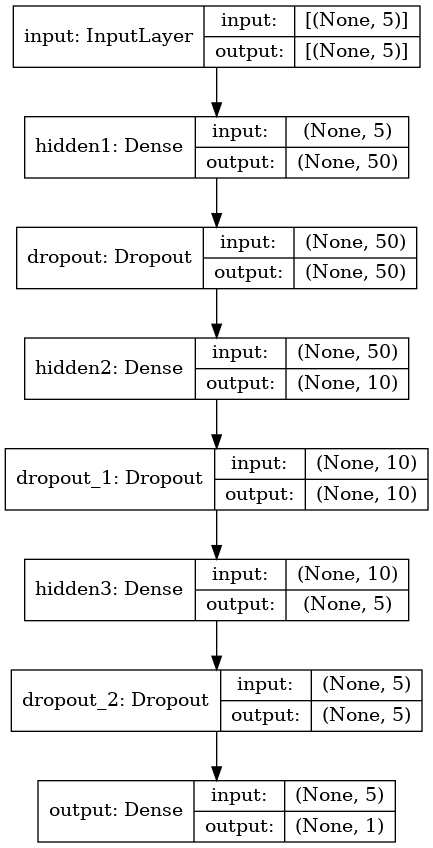

In [20]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [21]:
# The student can have his/her model saved:
model_file = 'ANN_model.h5'

##Call functions implementation to monitor the chosen metrics
checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             mode='min',
                                             save_best_only = True)

#Stop training when a monitored metric has stopped improving
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                           mode='min',# quantity that has to be monitored(to be minimized in this case)
                              patience = 50, # Number of epochs with no improvement after which training will be stopped.
                              min_delta = 1e-7,
                              restore_best_weights = True) # update the model with the best-seen weights

#Reduce learning rate when a metric has stopped improving
reduce_LR = keras.callbacks.ReduceLROnPlateau( monitor = 'val_loss',
                                              mode='min',# quantity that has to be monitored
                                              min_delta=1e-7,
                                              factor = 0.1, # factor by which LR has to be reduced...
                                              patience = 10, #...after waiting this number of epochs with no improvements 
                                              #on monitored quantity
                                              min_lr= 0.00001 ) 


callback_list = [reduce_LR, early_stop, checkpoint]
#callback_list = [checkpoint]
#callback_list = [ early_stop, checkpoint]


In [22]:
# Number of training epochs
# nepochs=500
nepochs=200
# Batch size
batch=250
# Train classifier (2 minutes more or less)
history = model.fit(X_train_val[:,0:NINPUT], 
                    Y_train_val,
                    epochs=nepochs, 
                    sample_weight=W_train_val,
                    batch_size=batch,
                    callbacks = callback_list, 
                    verbose=1, # switch to 1 for more verbosity 
                    validation_split=0.3 ) # fix the validation dataset size


Epoch 1/200
258/258 [==============================] - 9s 23ms/step - loss: 1.1518e-05 - accuracy: 0.7492 - weighted_accuracy: 0.7565 - val_loss: 9.7225e-06 - val_accuracy: 0.8333 - val_weighted_accuracy: 0.8213
Epoch 2/200
258/258 [==============================] - 2s 9ms/step - loss: 9.2399e-06 - accuracy: 0.8244 - weighted_accuracy: 0.8087 - val_loss: 7.2049e-06 - val_accuracy: 0.8239 - val_weighted_accuracy: 0.8260
Epoch 3/200
258/258 [==============================] - 3s 12ms/step - loss: 7.2813e-06 - accuracy: 0.8179 - weighted_accuracy: 0.8160 - val_loss: 6.3505e-06 - val_accuracy: 0.8205 - val_weighted_accuracy: 0.8319
Epoch 4/200
258/258 [==============================] - 3s 12ms/step - loss: 6.6951e-06 - accuracy: 0.8066 - weighted_accuracy: 0.8192 - val_loss: 6.0237e-06 - val_accuracy: 0.8155 - val_weighted_accuracy: 0.8386
Epoch 5/200
258/258 [==============================] - 3s 11ms/step - loss: 6.4238e-06 - accuracy: 0.8001 - weighted_accuracy: 0.8266 - val_loss: 5.6990e

In [23]:
model = keras.models.load_model('ANN_model.h5')

#Description of the Random Forest (RF) and Scikit-learn library

In this section you will find the following subsections:
* **Introduction to the Random Forest algorithm**<br>
If you have the knowledge about RF you may skip it.
* **Optional exercise: draw a decision tree**<br>
Here you find an atypical exercise in which it is suggested to think about the growth of a decision tree in this specific physics problem.

Here we will use it to build a Random Forest Model and compare its discriminating power w.r.t. the Neural Network previously implemented.

##What is Scikit-learn library?
Scikit-learn is a simple and efficient free-access tool for predictive data analysis and it can be used in various contexts. It is built on NumPy, SciPy, and matplotlib.




##Introduction to the Random Forest algorithm

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2016.07.15.png" width="400" align="right" /><br>


Decision Trees and their extension Random Forests are robust and easy-to-interpret machine learning algorithms for classification tasks.

Decision Trees represent a simple and fast way of learning a function that maps data x to outputs y, where x can be a mix of categorical and numericvvariables and y can be categorical for classification, or numeric for regression.

###Comparison with Neural Networks
(Deep) Neural Networks pretty much do the same thing. However, despite their power against larger and more complex datasets, they are *extremely hard to interpret* and they can take many iterations and hyperparameter adjustments before a good result is obtained.

One of the biggest advantages of using Decision Trees and Random Forests is the
ease in which we can see what features or variables contribute to the classification or regression and their relative importance based on their location depthwise in the tree.

###Decision Tree

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2016.13.21.png" width="400" align="left"/><br>

A decision tree is a sequence of selection cuts that are applied in a specified order on a given variable dataset.

Each cut splits the sample into nodes, each of which corresponds to a given number of observations classified as class1 (*signal*) or
as class2 (*background*). 

A node may be further split by the application of the subsequent cut in the
tree. Nodes in which either signal or background are largely dominant are classified as leafs, and no further selection is applied.

A node may also be classified as *leaf*, and the selection path is stopped, in case too few observations per node are counted, or in case the total number of identified nodes is too large, and different criteria have been proposed and applied in real implementations.

Each branch on a tree represents
one sequence of cuts.
Along the decision tree, the same variable may appear multiple times, depending on the depth of the tree, each time with a different applied cut, possibly even with different inequality directions.

Selection cuts can be tuned in order to achieve the best split level in each node according to some metrics (Gini index, cross-entropy...). Most of them are related to the *purity of a node*, that is the fraction of signal events over the whole events set in a given node P=S/(S+B).

The gain due to the splitting of a node A into the nodes B1 and B2, which depends on the chosen cut, is given by $\Delta I = I(A)- I(B1) - I(B2)$ , where I denotes the adopted metric (G or E, in case of the Gini index or cross-entropy introduced above). By varying the cut, the optimal gain may be achieved.

####Pruning Tree
<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2016.24.02.png" width="500" height="200" align="right" /><br>
A solution to the overtraining is pruning, which is eliminating subtrees (branches) that seem too specific to the training sample:
* a node and all its descendants turn into a leaf
* stop tree growth during the building phase

Be Careful: early stopping conditions may prevent from discovering further useful splitting. Therefore, grow the full tree and when results from subtrees are not significantly different from results coming from the parent one, prune them!

###From tree to the forest

The random forest algorithm consists of ‘growing’ a large number of individual decision trees that operate as an ensemble from replicas of the training samples obtained by randomly resampling the input data (features and examples).
<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2016.37.10.png" width="400" align="right"/><br>
Its main characteristics are:

* No minimum size is required for leaf nodes.
The final score of the algorithm is given by an
unweighted average of the prediction (zero or
one) by each individual tree.

* Each individual tree in the random forest splits
out a class prediction and the class with the
most votes becomes our model’s prediction.

* As a large number of relatively uncorrelated
models (trees) operating as a committee,this algorithm will
outperform any of the individual constituent
models. The reason for this wonderful effect is that the
trees protect each other from their individual
errors (as long as they don’t constantly all err
in the same direction). While some trees may be wrong, many
other trees will be right, so as a group the
trees are able to move in the correct
direction.

* In a single decision tree, we consider every possible feature and pick the one that produces the best separation between the observations in
the left node vs. those in the right node. In contrast, each tree in a random forest can pick only from a random subset of features (bagging).This forces even more variation amongst the trees in the model and ultimately results in lower correlation across trees and more diversification.


###Feature importance 

The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples to which they contribute can thus be used as an estimate of the relative importance of the features. In scikit-learn, the fraction of samples to which a feature contributes is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature.


**Warning:** The impurity-based feature importances computed on tree-based models suffer from two flaws that can lead to misleading conclusions:

* They are computed on statistics derived from the training dataset and therefore do not necessarily inform us on which features are most important to make good predictions on the held-out dataset. 
* They favor high cardinality features, that are featured with many unique values. Permutation feature importance is an alternative to impurity-based feature importance that does not suffer from these flaws. 

Due to its complexity, we will not use it in this exercise. For more details, see the following link:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html.



##Optional exercise : Draw a decision tree
**Exercise for students**: Here it is an example of how you can build a decision tree by yourself! Try to imagine how could be the decision tree's growth in our analysis case and complete it! We give you some hints!

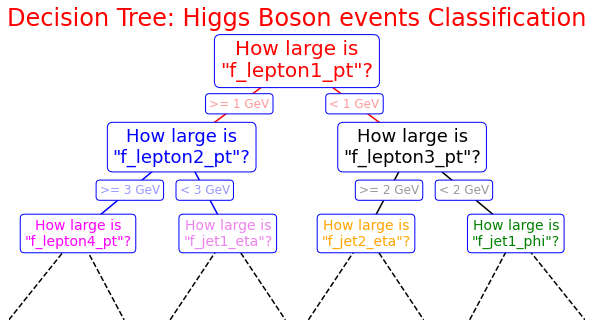

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Decision Tree: Higgs Boson events Classification', size=24,color='red')

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict( boxstyle='round', ec='blue', fc='w' ), **kwargs)
    
# Here you are the variables we can use for the training phase:
# --------------------------------------------------------------------------
# High level features:
# ['f_massjj', 'f_deltajj', 'f_mass4l', 'f_Z1mass' , 'f_Z2mass']
# --------------------------------------------------------------------------
# Low level features:
#        [ 'f_lept1_pt','f_lept1_eta','f_lept1_phi', \
#          'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
#          'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
#          'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
#          'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
#          'f_jet2_pt','f_jet2_eta','f_jet2_phi']
#---------------------------------------------------------------------------
text(ax, 0.5, 0.9, "How large is\n\"f_lepton1_pt\"?", 20,color='red')
text(ax, 0.3, 0.6, "How large is\n\"f_lepton2_pt\"?", 18,color='blue')
text(ax, 0.7, 0.6, "How large is\n\"f_lepton3_pt\"?", 18)
text(ax, 0.12, 0.3, "How large is\n\"f_lepton4_pt\"?", 14,color='magenta')
text(ax, 0.38, 0.3, "How large is\n\"f_jet1_eta\"?", 14,color='violet')
text(ax, 0.62, 0.3, "How large is\n\"f_jet2_eta\"?", 14,color='orange')
text(ax, 0.88, 0.3, "How large is\n\"f_jet1_phi\"?", 14,color='green')

text(ax, 0.4, 0.75, ">= 1 GeV", 12, alpha=0.4,color='red')
text(ax, 0.6, 0.75, "< 1 GeV", 12, alpha=0.4,color='red')

text(ax, 0.21, 0.45, ">= 3 GeV", 12, alpha=0.4,color='blue')
text(ax, 0.34, 0.45, "< 3 GeV", 12, alpha=0.4,color='blue')

text(ax, 0.66, 0.45, ">= 2 GeV", 12, alpha=0.4,color='black')
text(ax, 0.79, 0.45, "< 2 GeV", 12, alpha=0.4,color='black')

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k',color='red')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k',color='blue')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

fig.savefig('05.08-decision-tree.png')

#Random Forest implementation

Now you can start to define a second ML architecture setting the tree construction parameters to fix:

* the assignment of a terminal node to a class;
* the stop splitting of the single tree;
* selection criteria of splits.

##Grid Search for Parameter estimation

A machine learning model has two types of parameters. The first type are the **parameters** that are learned through a machine learning model while the second type are the **hyperparameters**  whose value is used to control the learning process.

Hyperparameters can be thought of as model settings. These settings need to be tuned for each problem because the best model hyperparameters for one particular dataset will not be the best across all datasets. 

The process of *hyperparameter tuning* (also called *hyperparameter optimization*) means finding the combination of hyperparameter values for a machine learning model that performs the best - as measured on a validation dataset - for a problem.

Normally we set the value for these hyperparameters by hand, as we did for our ANN, and see which parameters reach the best performance. However, randomly selecting the parameters for the algorithm can be exhaustive.

Therefore, instead of randomly selecting the values of the parameters, a better approach would be to develop an algorithm which automatically finds the best parameters for a particular model. Grid Search is one of such algorithms.

Hyperparameter optimization algorithms usually finds a tuple of hyperparameters that yields an optimal model which maximizes a predefined **metric** on a given independent data.The metric takes a tuple of hyperparameters and returns the associated value. [Cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is often used to estimate this generalization performance.









In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV

Let's implement the grid search algorithm for our Random Forest discriminator!

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="300" align="right"/>
<br>
Grid Search algorithm basically tries all possible combinations of parameter values and returns the combination with the **highest accuracy**. 
The Grid Search algorithm can be very slow, owing to the potentially huge number of combinations to test. Furthermore, performing **cross-validation** considerably increases the execution time of the process! <br>For these reasons, the algorithm is commented on the following code cells and images of the outputs are left to you!<br>

To read more about cross-validation on Scikit-learn:

[Cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html)
<br>
To read more about GridSearchCV algorithm on Scikit-learn: 

[GridSearchCV algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)


In [26]:
#classifier = RandomForestClassifier(random_state=7)

In [27]:
# The first step we need to perform is to 
# create a dictionary of all the parameters and their corresponding 
# set of values that you want to test for best performance. 
# The name of the dictionary items corresponds to the parameter name 
# and the value corresponds to the list of values for the parameter.
# The parameter values that we want to try out 
# are passed in the list. In the below code we want to find 
# which values of the RF hyperparameters provides the highest accuracy

#grid_param = {
#     'criterion': ['gini','entropy'],
#    'n_estimators': [300, 500],
#    'bootstrap': [True, False],
#    'max_depth': [3,5],
#    'min_samples_leaf':[300,500],
#    'min_samples_split':[200,400],
#    'max_features':[3,4,5]
# }

In [28]:
# Once the parameter dictionary is created, 
# the next step is to create an instance of the GridSearchCV class. 
# You need to pass values for the estimator parameter, 
# which basically is the algorithm that you want to execute. 
# The param_grid parameter takes the parameter dictionary that we 
# just created as parameter, the scoring parameter takes the performance metrics, 
# the cv parameter corresponds to number of folds, 
# which is 5 in our case, and finally the n_jobs parameter refers to the 
# number of CPU's that you want to use for execution. 
# A value of -1 for n_jobs parameter means that use all available computing power. 
# This can be handy if you have large number amount of data.

#gd_sr = GridSearchCV(estimator=classifier,
#                     param_grid=grid_param, #parameter dictionary
#                     scoring='accuracy', #performance metrics
#                     cv=3, #number of folds
#                     n_jobs=-1) #use all available computing power

In [29]:
# Time required : 7h 50 minutes
# gd_sr.fit(X_train_val, np.ravel(Y_train_val))

Output of the previous code cell:

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-20%20alle%2020.09.14.png" width="600"  /><br>

In [30]:
#best_parameters = gd_sr.best_params_
#print('Best parameters:')
#print(best_parameters)
#best_result = gd_sr.best_score_
#print('Best metrics score (accuracy):')
#print(best_result)

Output of the previous code cell:

<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-20%20alle%2020.10.46.png" width="600"  /><br>
<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-20%20alle%2020.10.55.png" width="600"  /><br>


In [31]:
# Best parameters:

# {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': 4, 
# 'min_samples_leaf': 500, 'min_samples_split': 200, 'n_estimators': 300}
# Best metrics score (accuracy):
# 0.9199343250564441
rfc=RandomForestClassifier( n_estimators=300,criterion='gini',
                           verbose=0 , min_samples_split=200, 
                           max_depth= 5,min_samples_leaf=500, 
                           max_features=4, bootstrap=False,random_state=7 )

In [32]:
# Use the same sets X_train_val, X_test, Y_train_val, Y_test , W_train_val , 
# W_test used for the ANN in order to train our Random Forest algorithm

randomforest=rfc.fit(X_train_val,np.ravel(Y_train_val),np.ravel(W_train_val))

In the following few lines of code, the random forest model which we created in the previous step is saved as a **.pkl file** so that you can load it as a new object called **pickled_model** in another notebook!

In [33]:
import pickle

# Save to file in the current working directory
pkl_filename = "rf_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rfc, file)


# Performance evaluation

In this section you will find the following subsections:
* **ROC curve and Rates definitions**<br>
* **Overfitting and test evaluation of an MVA model**<br>
If you have the knowledge about these theoretical concepts you may skip it.
* **Artificial Neural Network performance**
* **Exercise 1 - Random Forest performance**<br>
Here you will re-do the procedure followed for the ANN in order to evaluate the Random Forest performance. <br>
Finally, you will compare the discriminating performance of the two trained ML models. 

## ROC curve and rates definitions

There are many ways to evaluate the quality of the prediction of a model. In the ANN implementation, we evaluated the accuracy metric and the loss of the training and validation samples.

Another largely used evaluation metric for binary classification tasks is the *Receiver Operating Characteristic* curve or **ROC curve**.

First, we introduce the terms `positive` and `negative` referring to the classifier’s prediction, and the terms `true` and `false` referring to whether the network prediction corresponds to the observation (the "truth" level). In our Higgs boson binary classification exercise, we can think the `negative` outcome as the one labeling background (that, in the last sigmoid layer of our network, would mean a number close to 0 - in the Random Forest score would mean a number equals to zero), and the `positive` outcome as the one labeling signal (that, in the last sigmoid layer of our network, would mean a number close to 1 - random forest score equals to zero). 

* **TP (true positive)**: the event is signal, the prediction is signal (*correct result*)
* **FP (false positive)**: the event is background, but the prediction is signal (*unexpected result*)
* **TN (true negative)**: the event is background, the prediction is background (*correct absence of signal*)
* **FN (false negative)**: the event is signal, the prediction is background (*missing a true signal event*)

Some additional definitions:

* **TPR (true positive rate)**: how often the network predicts a positive outcome (*signal*), when the input is positive (*signal*):  $TPR = \frac{TP}{TP+FN}$
* **FPR (false positive rate)**: how often the network predicts a positive outcome (*signal*), when the input is negative (*background*) : $FPR = \frac{FP}{FP+TN}$

A good classifier should give a high TPR and a small FPR.

Quoting wikipedia:

"A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, probability of detection, or signal efficiency in high energy physics. The false-positive rate is also known as the probability of false alarm or fake rate in high energy physics."

The ROC curve requires the true binary value (0 or 1, background or signal) and the probability estimates of the positive (signal) class.

The **`roc_auc_score`** function computes the area under the receiver operating characteristic (ROC) curve, which is also denoted by AUC. By computing the area under the roc curve, the curve information is summarized in one number. 

For more information see: [https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).


The AUC is the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one. The higher the AUC, the better the performance of the classifier. If the AUC is 0.5, the classifier is uninformative, i.e., it will rank equally a positive or a negative observation.

##Other metrics


The **precision/purity** is the ratio $\frac{TP}{TP + FP} $where TP is the number of true positives and FP the number of false positives. 
The precision is intuitively the ability of the classifier not to label as positive a sample
that is negative.


The **recall/sensitivity/TPR/signal efficiency** is the ratio $\frac{TP}{TP + FN}$ where TP is the number of
true positives and FN the number of false negatives. The recall is
intuitively the ability of the classifier to find all the positive samples.


**Accuracy** is defined as the number of good matches between the predictions and the true labels:

$\text{Accuracy} =\frac{\text{Number of correct predictions}}{\text{Total number of predictions}}$.

<p>For binary classification, accuracy can also be calculated in terms of positives and negatives as follows:</p>

<div class="left-align">
$$\text{Accuracy} = \frac{TP+TN}{TP+TN+FP+FN}$$
</div>


You can always achieve high accuracy on skewed/unbalanced datasets by predicting the most the same output (the most common one) for every input. Thus the another metric, **F1** can be used when there are more positive examples than negative examples. It is defined in terms of the precision and recall as **(2 * precision * recall) / (precision + recall)**. In our case, we will use a simplification of this metric that is the product **signal*efficiency**.

In [34]:
#Let's import all the metrics that we need later on!
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,accuracy_score , precision_score , recall_score , precision_recall_curve , roc_curve, auc , roc_auc_score 


### Overfitting and test evaluation of an MVA model
<img src="https://raw.githubusercontent.com/bdanzi/Higgs_exercise/main/Schermata%202021-04-10%20alle%2015.51.23.png" style="display: block; margin: auto;" width="400" align="right"/><br><br><br>
The loss function and the accuracy metrics give us a measure of the **overtraining (overfitting)** of the ML algorithm. Over-fitting happens when an ML algorithm learns to recognize a pattern that is primarily based on the training (validation) sample and that is nonexistent when looking at the testing (training) set (see the plot on the right side to understand what we would expect when overfitting happens).


## Artificial Neural Network performance



Let's see what we obtained from our ANN model training making some plots!

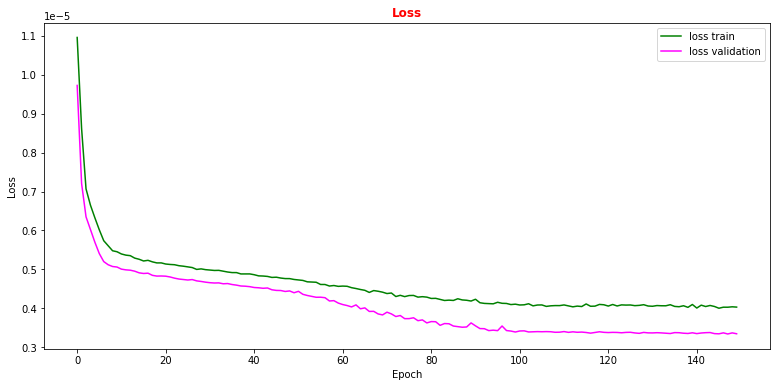

In [35]:
# plot the loss fuction vs epoch during the training phase
# the plot of the loss function on the validation set is also computed and plotted
plt.rcParams['figure.figsize'] = (13,6)
plt.plot(history.history['loss'], label='loss train',color='green')
plt.plot(history.history['val_loss'], label='loss validation',color='magenta')
plt.title("Loss", fontsize=12,fontweight='bold', color='r')
plt.legend(loc="upper right")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

**Question to student:** Why does the validation loss decrease more than the training loss? 

**Hint**: remember we used several call functions to train our ANN.

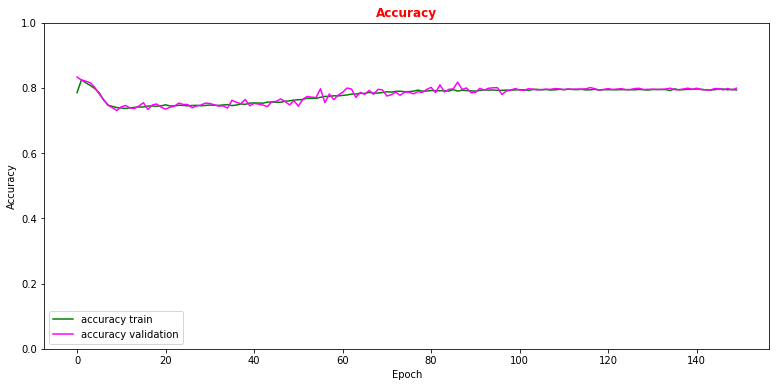

In [36]:
# Plot accuracy metrics vs epoch during the training
# for the proper training dataset and the validation one
plt.rcParams['figure.figsize'] = (13,6)
plt.plot(history.history['accuracy'], label='accuracy train',color='green')
plt.plot(history.history['val_accuracy'], label='accuracy validation',color='magenta')
plt.title("Accuracy",fontsize=12,fontweight='bold', color='r')
plt.ylim([0, 1.0])
plt.legend(loc="lower left")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Now let's use our **test dataset** in order to see which are the performance of our model on a never-seen-before dataset and make comparison with what we obtained with the **training dataset**!

In [37]:
# Get ANN model label predictions and performance metrics curves, after having trained the model
y_true = Y_test[:,0]
y_true_train = Y_train_val[:,0]
w_test = W_test[:,0]
w_train = W_train_val[:,0]
Y_prediction = model.predict(X_test[:,0:NINPUT])

# Get precision, recall, 
p, r, t = precision_recall_curve( y_true= Y_test, probas_pred= Y_prediction , 
                                 sample_weight=w_test )
# Get False Positive Rate (FPR) True Positive Rate (TPR) , Thresholds/Cut on the ANN's score
fpr, tpr, thresholds = roc_curve( y_true= Y_test,  y_score= Y_prediction, sample_weight=w_test )


Y_prediction_train = model.predict(X_train_val[:,0:NINPUT])
p_train, r_train, t_train = precision_recall_curve( Y_train_val, Y_prediction_train ,
                                                   sample_weight=w_train )
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train_val, Y_prediction_train,
                                                   sample_weight=w_train)


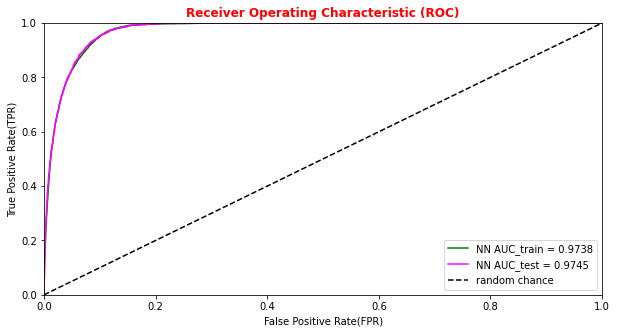

In [38]:
# Plotting the ANN ROC curve on the test and training datasets
roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train,tpr_train)
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(fpr_train, tpr_train,  color='green', label='NN AUC_train = %.4f' % (roc_auc_train))
plt.plot(fpr, tpr, color='magenta', label='NN AUC_test = %.4f' % (roc_auc))
# Comparison with the random chance curve
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='random chance')
plt.xlim([0, 1.0]) #fpr
plt.ylim([0, 1.0]) #tpr
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC)',fontsize=12,fontweight='bold', color='r')
plt.legend(loc="lower right")
plt.show()

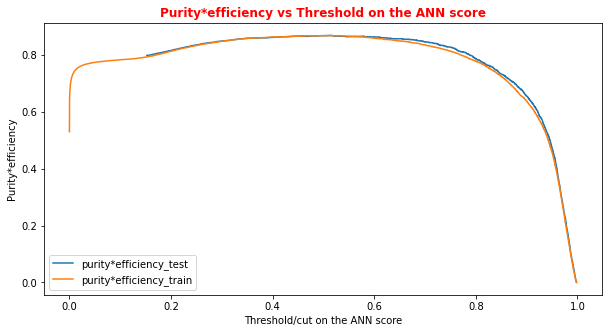

In [39]:
# Plot of the metrics Efficiency x Purity -- ANN 
# Looking at this curve we will choose a threshold on the ANN score
# for distinguishing between signal and background events
#plt.plot(t, p[:-1], label='purity_test')
#plt.plot(t_train, p_train[:-1], label='purity_train')
#plt.plot(t, r[:-1], label='efficiency_test')
#plt.plot(t_train, r_train[:-1], label='efficiency_test')
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(t,p[:-1]*r[:-1],label='purity*efficiency_test')
plt.plot(t_train,p_train[:-1]*r_train[:-1],label='purity*efficiency_train')
plt.xlabel('Threshold/cut on the ANN score')
plt.ylabel('Purity*efficiency')
plt.title('Purity*efficiency vs Threshold on the ANN score',fontsize=12,fontweight='bold', color='r')
#plt.tick_params(width=2, grid_alpha=0.5)
plt.legend(markerscale=50)
plt.show()

In [40]:

# Print metrics imposing a threshold for the test sample. In this way the student
# can use later the model's score to discriminate signal and bkg events for a fixing
# score

cut_dnn=0.6

# Transform predictions into a array of entries 0,1 depending if prediction is beyond the
# chosen threshold
y_pred = Y_prediction[:,0] 
y_pred[y_pred >= cut_dnn]= 1 #classify them as signal
y_pred[y_pred < cut_dnn]= 0 #classify them as background
y_pred_train = Y_prediction_train[:,0]
y_pred_train[y_pred_train>=cut_dnn]=1
y_pred_train[y_pred_train<cut_dnn]=0

print("y_true.shape",y_true.shape)
print("y_pred.shape",y_pred.shape)
print("w_test.shape",w_test.shape)
print("Y_prediction",Y_prediction)
print("y_pred",y_pred)


y_true.shape (22997,)
y_pred.shape (22997,)
w_test.shape (22997,)
Y_prediction [[1.]
 [1.]
 [0.]
 ...
 [0.]
 [1.]
 [1.]]
y_pred [1. 1. 0. ... 0. 1. 1.]


In [41]:
# Other Metrics values for the ANN algorithm having fixed an ANN score threshold
accuracy  = accuracy_score(y_true, y_pred, sample_weight=w_test)
precision = precision_score(y_true, y_pred, sample_weight=w_test)
recall    = recall_score(y_true, y_pred, sample_weight=w_test)
f1 = 2*precision*recall/(precision+recall)
cm = confusion_matrix( y_true, y_pred, sample_weight=w_test)
print('Cut/Threshold on the ANN output : %.4f' % cut_dnn)
print('ANN Test Accuracy: %.4f' % accuracy)
print('ANN Test Precision/Purity: %.4f' % precision)
print('ANN Test Sensitivity/Recall/TPR/Signal Efficiency: %.4f' % recall)
print('ANN Test F1: %.4f' %f1)
print('')


Cut/Threshold on the ANN output : 0.6000
ANN Test Accuracy: 0.9264
ANN Test Precision/Purity: 0.9063
ANN Test Sensitivity/Recall/TPR/Signal Efficiency: 0.9524
ANN Test F1: 0.9288



The information from the evaluation metrics can be summarised in a so-called **confusion matrix** whose elements, from the top-left side, represent TN, FP, FN and TP rates. 

Cut/Threshold on the ANN output : 0.6000 

Confusion matrix ANN



Text(0.5, 1.0, 'Normalized Confusion Matrix for the Test dataset - Artificial Neural Network ')

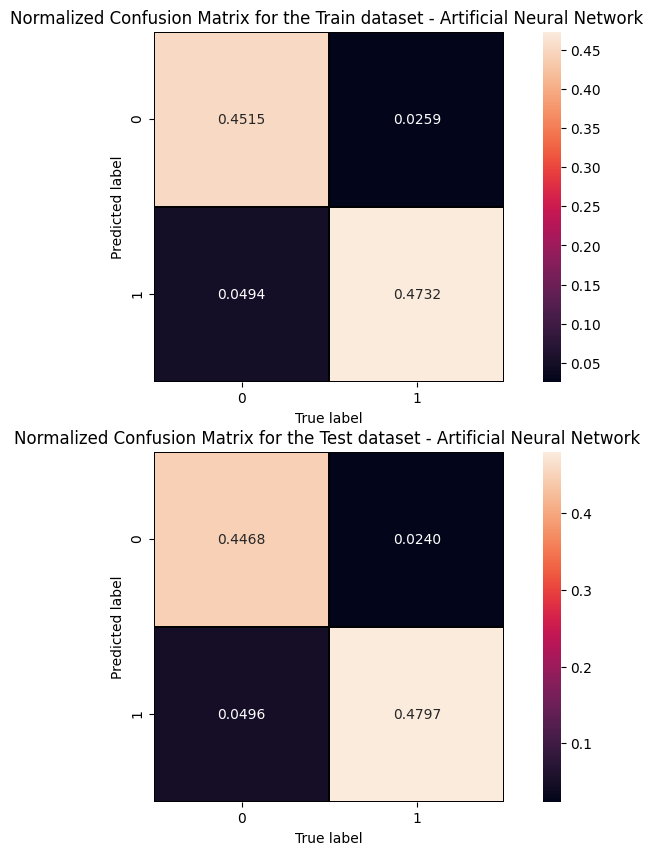

In [42]:
print('Cut/Threshold on the ANN output : %.4f \n' % cut_dnn )
print('Confusion matrix ANN\n')

plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(10,10) )


plt.subplot(2,1,1)
mat_train = confusion_matrix(y_true_train, y_pred_train,sample_weight=w_train,normalize='all')
sns.heatmap(mat_train.T, square=True, annot=True, fmt='.4f', cbar=True,linewidths=1,linecolor='black' )
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.title('Normalized Confusion Matrix for the Train dataset - Artificial Neural Network ')

plt.subplot(2, 1, 2)
mat_test = confusion_matrix(y_true, y_pred ,sample_weight=w_test,normalize='all' )
sns.heatmap(mat_test.T, square=True, annot=True, fmt='.4f', cbar=True,linewidths=1,linecolor='black')
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.title('Normalized Confusion Matrix for the Test dataset - Artificial Neural Network ')


An alternative way to check overfitting, and choosing correctly a threshold for selecting signal events, is plotting signal and background ANN predictions for the training and test datasets. If the distributions are quite similar it means that the algorithm learned how to generalize! <br> For measuring quantitatively the overfitting one can perform a [**Kolmogorov-Smirnov**](https://en.wikipedia.org/wiki/Kolmogorov–Smirnov_test) test that we will not implement here.

In [43]:
# Let's get signal and background events for both test and training dataset!

df_sig  = df['sig'].filter(NN_VARS)
df_bkg  = df['bkg'].filter(NN_VARS)

X_sig  = np.asarray( df_sig.values ).astype(np.float32)
X_bkg  = np.asarray( df_bkg.values ).astype(np.float32)

df_test = df_all.iloc[0:test_size+1]
df_train = df_all.iloc[test_size+1:size]

df_test_sig = df_test[(df_test['isSignal']>=1)].filter(NN_VARS)
df_test_bkg = df_test[(df_test['isSignal']<1)].filter(NN_VARS)

df_train_sig = df_train[(df_train['isSignal']>=1)].filter(NN_VARS)
df_train_bkg = df_train[(df_train['isSignal']<1)].filter(NN_VARS)

X_test_sig  = np.asarray( df_test_sig.values ).astype(np.float32)
X_test_bkg  = np.asarray( df_test_bkg.values ).astype(np.float32)
X_train_sig  = np.asarray( df_train_sig.values ).astype(np.float32)
X_train_bkg  = np.asarray( df_train_bkg.values ).astype(np.float32)

print('Test dataset shape:')
print(df_test.shape)
print('Test dataset signal shape:')
print(df_test_sig.shape)
print('Test dataset background shape:')
print(df_test_bkg.shape)
print('Training dataset shape' )
print(df_train.shape)
print('Training signal dataset shape' )
print(df_train_sig.shape)
print('Training background dataset shape' )
print(df_train_bkg.shape)

Y_test_sig = model.predict(X_test_sig) #flag predicted on all signal events
Y_test_bkg = model.predict(X_test_bkg) #flag predicted on all background events
Y_train_sig = model.predict(X_train_sig)
Y_train_bkg = model.predict(X_train_bkg)

Test dataset shape:
(22997, 27)
Test dataset signal shape:
(2870, 5)
Test dataset background shape:
(20127, 5)
Training dataset shape
(91987, 27)
Training signal dataset shape
(11390, 5)
Training background dataset shape
(80597, 5)


In [44]:
df_test.head()

,f_run,f_event,f_weight,f_massjj,f_deltajj,f_mass4l,f_Z1mass,f_Z2mass,f_lept1_pt,f_lept1_eta,...,f_lept4_pt,f_lept4_eta,f_lept4_phi,f_jet1_pt,f_jet1_eta,f_jet1_phi,f_jet2_pt,f_jet2_eta,f_jet2_phi,isSignal
9101,1,80913,0.000075,499.415680,3.541091,123.750252,69.386528,22.196232,47.066288,-1.938778,...,16.923937,0.011259,-0.304338,83.238281,-2.022697,1.945629,84.314346,1.518393,-2.281762,1.0
61307,1,1799470,0.000004,1034.700684,5.445127,123.126251,87.025040,30.899391,54.302334,1.254665,...,11.106866,0.836214,0.240992,88.764404,-1.835088,-2.809269,52.351109,3.610039,-2.063801,0.0
434065,1,48636330,0.000015,131.100220,1.032331,224.591537,90.623093,115.573257,64.985748,1.022329,...,41.790005,-0.187201,2.840212,114.500084,0.614150,3.130475,32.397049,1.646480,-0.925176,0.0
755935,1,54379498,0.000004,83.658073,1.574079,201.779816,95.846970,85.438805,72.073616,0.108228,...,13.022590,1.919428,1.664050,46.515545,1.133949,0.139815,44.397335,-0.440129,0.533251,0.0
504179,1,98493569,0.000001,652.359863,3.799881,335.023987,90.216057,92.984535,126.748039,1.168150,...,14.898630,-0.470465,0.317107,99.428864,-3.475805,2.928077,99.210449,0.324076,-3.102045,0.0


In [45]:
df_all.head()

,f_run,f_event,f_weight,f_massjj,f_deltajj,f_mass4l,f_Z1mass,f_Z2mass,f_lept1_pt,f_lept1_eta,...,f_lept4_pt,f_lept4_eta,f_lept4_phi,f_jet1_pt,f_jet1_eta,f_jet1_phi,f_jet2_pt,f_jet2_eta,f_jet2_phi,isSignal
9101,1,80913,0.000075,499.415680,3.541091,123.750252,69.386528,22.196232,47.066288,-1.938778,...,16.923937,0.011259,-0.304338,83.238281,-2.022697,1.945629,84.314346,1.518393,-2.281762,1.0
61307,1,1799470,0.000004,1034.700684,5.445127,123.126251,87.025040,30.899391,54.302334,1.254665,...,11.106866,0.836214,0.240992,88.764404,-1.835088,-2.809269,52.351109,3.610039,-2.063801,0.0
434065,1,48636330,0.000015,131.100220,1.032331,224.591537,90.623093,115.573257,64.985748,1.022329,...,41.790005,-0.187201,2.840212,114.500084,0.614150,3.130475,32.397049,1.646480,-0.925176,0.0
755935,1,54379498,0.000004,83.658073,1.574079,201.779816,95.846970,85.438805,72.073616,0.108228,...,13.022590,1.919428,1.664050,46.515545,1.133949,0.139815,44.397335,-0.440129,0.533251,0.0
504179,1,98493569,0.000001,652.359863,3.799881,335.023987,90.216057,92.984535,126.748039,1.168150,...,14.898630,-0.470465,0.317107,99.428864,-3.475805,2.928077,99.210449,0.324076,-3.102045,0.0


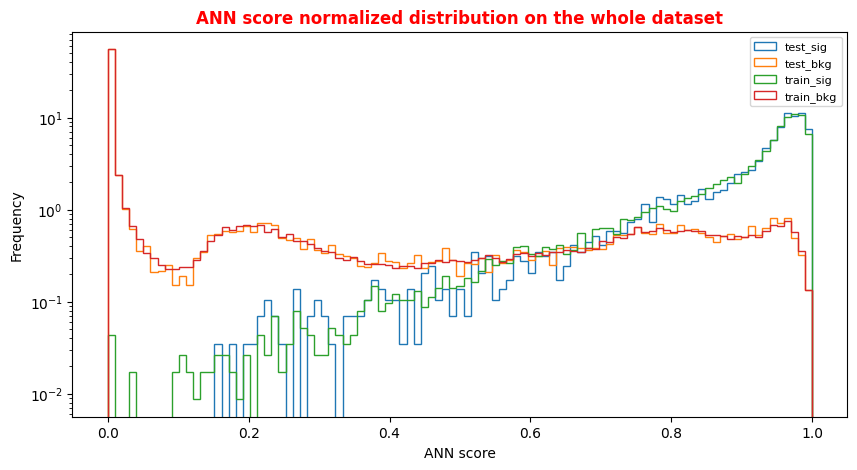

In [46]:
# Normalized Distribution of the ANN score for the whole dataset
# ax = plt.subplot(4, 2, 4)
X = np.linspace(0.0, 1.0, 100) #100 numbers between 0 and 1
plt.rcParams['figure.figsize'] = (10,5)
hist_test_sig = plt.hist(Y_test_sig, bins=X, label='test_sig',histtype='step',log=True,density=1)
hist_test_bkg = plt.hist(Y_test_bkg, bins=X, label='test_bkg',histtype='step',log=True,density=1)
hist_train_sig = plt.hist(Y_train_sig, bins=X, label='train_sig',histtype='step',log=True,density=1)
hist_train_bkg = plt.hist(Y_train_bkg, bins=X, label='train_bkg',histtype='step',log=True,density=1)
plt.xlabel('ANN score')
plt.ylabel('Frequency')
plt.legend( loc='upper right',prop={'size': 8} )
plt.title('ANN score normalized distribution on the whole dataset',fontsize=12,fontweight='bold', color='r')
plt.show()

## Exercise 1 - Random Forest performance

Evaluate the performance of the Random Forest algorithm. **Hint**: use the *predict_proba* method this time!



In [47]:
# Get RF model predictions and performance metric curves, after having trained the model

# Do it for the test dataset:
y_pred_rfc=randomforest.predict(X_test[:,0:NINPUT])
y_pred_rfc_prob= randomforest.predict_proba(X_test[:,0:NINPUT])
y_pred_rfc_proba = y_pred_rfc_prob[:,-1]
p_rf,r_rf,t_rf= precision_recall_curve(Y_test, probas_pred=y_pred_rfc_proba , sample_weight=w_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y_test, y_score=y_pred_rfc_proba, sample_weight=w_test  )

# Do the same for the training dataset:
y_pred_rfc_train=randomforest.predict(X_train_val[:,0:NINPUT])
y_pred_rfc_train_prob= randomforest.predict_proba(X_train_val[:,0:NINPUT])
y_pred_rfc_train_proba = y_pred_rfc_train_prob[:,-1] #last element associated to the signal probability
p_train_rf, r_train_rf, t_train_rf = precision_recall_curve(Y_train_val, y_pred_rfc_train_proba, sample_weight=w_train)
fpr_train_rf, tpr_train_rf, thresholds_train_rf = roc_curve(Y_train_val, y_pred_rfc_train_proba, sample_weight=w_train)



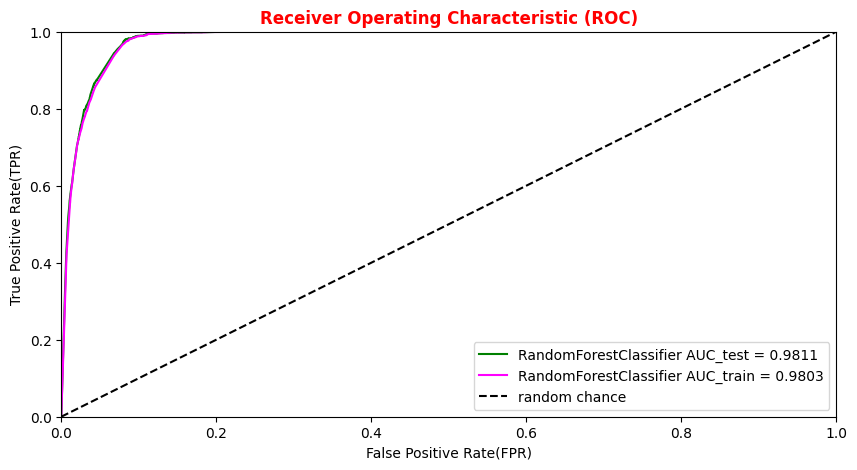

In [48]:
# Plotting the ROC curve for the Random Forest algorithm
roc_auc_rf = auc(fpr_rf,tpr_rf)
roc_auc_rf_train = auc(fpr_train_rf,tpr_train_rf)

plt.rcParams['figure.figsize'] = (10,5)
#Random Forest 1st method
plt.plot(fpr_rf,tpr_rf,  color='green', label='RandomForestClassifier AUC_test = %.4f' % (roc_auc_rf))
plt.plot(fpr_train_rf,tpr_train_rf, color='magenta', label='RandomForestClassifier AUC_train = %.4f' % (roc_auc_rf_train))
#Random Forest 2nd method : use the sklearn function "plot_roc_curve"
#rfc_disp = plot_roc_curve(rfc, X_train_val,Y_train_val,color='brown',ax=ax, sample_weight=w_train )
#rfc_disp = plot_roc_curve(rfc, X_test, Y_test, color='grey',ax=ax, sample_weight=w_test)
#random chance
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='random chance')
plt.xlim([0, 1.0]) #fpr
plt.ylim([0, 1.0]) #tpr
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC)',fontsize=12,fontweight='bold', color='r')
plt.legend(loc="lower right")
plt.show()

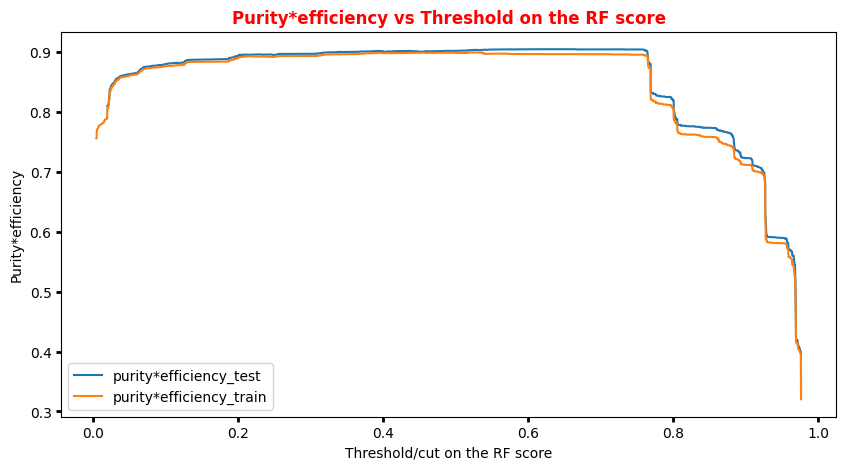

In [49]:
# Plot Efficiency x Purity -- Random Forest 

# Other metrics:
# plt.plot(t_rf, p_rf[:-1], label='purity_test')
# plt.plot(t_train_rf, p_train_rf[:-1], label='purity_test')
# plt.plot(t_rf, r_rf[:-1], label='efficiency_test')
# plt.plot(t_train_rf, r_train_rf[:-1], label='efficiency_train')
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(t_rf,p_rf[:-1]*r_rf[:-1],label='purity*efficiency_test')
plt.plot(t_train_rf,p_train_rf[:-1]*r_train_rf[:-1],label='purity*efficiency_train')
plt.ylabel('Purity*efficiency')
plt.xlabel('Threshold/cut on the RF score')
plt.title('Purity*efficiency vs Threshold on the RF score',fontsize=12,fontweight='bold', color='r')
plt.tick_params(width=2, grid_alpha=0.5)
plt.legend(markerscale=50)
plt.show()


In [50]:
# Random Forest score for training and test datasets (bkg and sig)

Y_sig_rfc = randomforest.predict_proba(X_sig) #probability of belonging to the signal(bkg) class for all signal events
Y_bkg_rfc = randomforest.predict_proba(X_bkg)  #probability of belonging to the signal(bkg) class for all bkg events
Y_test_sig_rf= randomforest.predict_proba(X_test_sig) # the same for all signal events in the test dataset
Y_test_bkg_rf = randomforest.predict_proba(X_test_bkg) # the same for all bkg events in the test dataset
Y_train_sig_rf = randomforest.predict_proba(X_train_sig) # the same for all sig events in the training dataset
Y_train_bkg_rf = randomforest.predict_proba(X_train_bkg) # the same for all bkg events in the training dataset





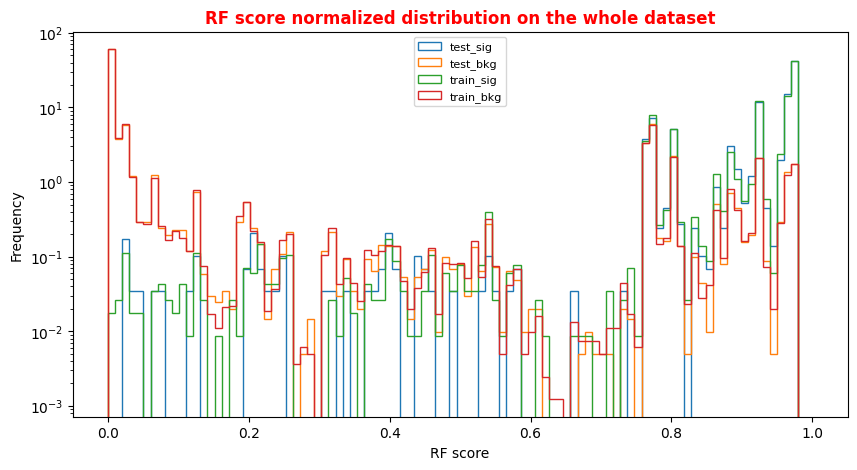

In [51]:
# Random Forest score Plot for the whole dataset
X = np.linspace(0.0, 1.0, 100) #100 numbers between 0 and 1
plt.rcParams['figure.figsize'] = (10,5)
hist_test_sig = plt.hist(Y_test_sig_rf[:,1], bins=X, label='test_sig',histtype='step',log=True,density=1 )
hist_test_bkg = plt.hist(Y_test_bkg_rf[:,1], bins=X, label='test_bkg',histtype='step',log=True,density=1)
hist_train_sig = plt.hist(Y_train_sig_rf[:,1], bins=X, label='train_sig',histtype='step',log=True,density=1)
hist_train_bkg = plt.hist(Y_train_bkg_rf[:,1], bins=X, label='train_bkg',histtype='step',log=True,density=1)
plt.xlabel('RF score')
plt.ylabel('Frequency')
plt.legend( loc='upper center',prop={'size': 8} )
plt.title('RF score normalized distribution on the whole dataset',fontsize=12,fontweight='bold', color='r')
plt.show()

In [52]:
# We choose a threshold on the RF score for labelling signal and background events looking at the 
# previous plots
cut_rf=0.6

y_pred_rfc[y_pred_rfc >= cut_rf]=1 #classify them as signal
y_pred_rfc[y_pred_rfc < cut_rf]=0 #classify them as background

#print("y_pred_rfc.shape",y_pred_rfc.shape)
#print("y_pred_rfc",y_pred_rfc)

#Metrics for the RandomForest
accuracy_rfc  = accuracy_score(y_true, y_pred_rfc, sample_weight=w_test) #fraction of correctly classified events
precision_rfc = precision_score(y_true, y_pred_rfc, sample_weight=w_test) #Precision of the positive class in binary classification
recall_rfc    = recall_score(y_true, y_pred_rfc, sample_weight=w_test) #Recall of the positive class in binary classification 
f1_rfc = 2*precision_rfc*recall_rfc/(precision_rfc+recall_rfc)
print('Cut/Threshold on the Random Forest output : %.4f' % cut_rf)
print('Random Forest Test Accuracy: %.4f' % accuracy_rfc)
print('Random Forest Test Precision/Purity:  %.4f' % precision_rfc)
print('Random Forest Test Sensitivity/Recall/TPR/Signal Efficiency: %.4f' % recall_rfc)
print('RF Test F1:   %.4f' %f1_rfc)
print('')

Cut/Threshold on the Random Forest output : 0.6000
Random Forest Test Accuracy: 0.9471
Random Forest Test Precision/Purity:  0.9180
Random Forest Test Sensitivity/Recall/TPR/Signal Efficiency: 0.9827
RF Test F1:   0.9492



Cut/Threshold on the Random Forest output : 0.6000


Text(0.5, 1.0, 'Normalized Confusion Matrix for the Test dataset - Random Forest ')

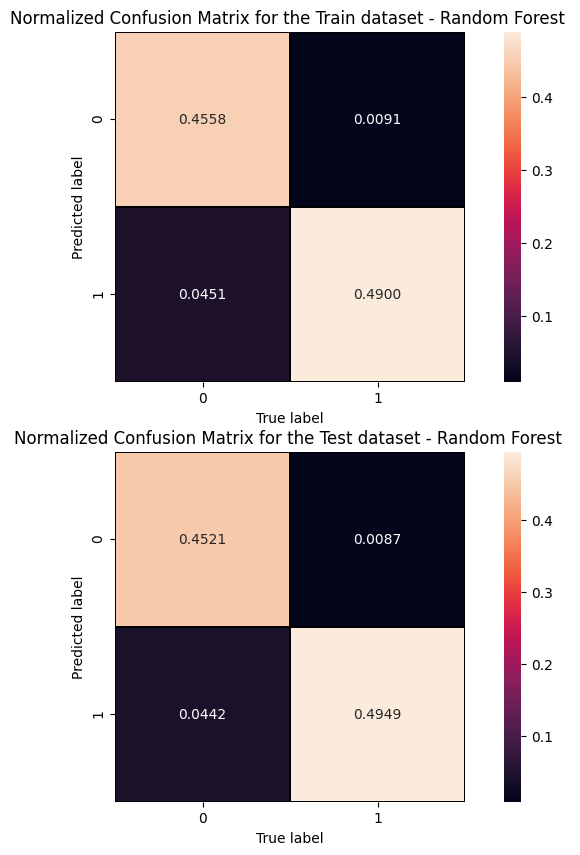

In [53]:
print('Cut/Threshold on the Random Forest output : %.4f' % cut_rf)
#cm_rfc = confusion_matrix( y_true, y_pred_rfc, sample_weight=w_test)
#disp_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc, display_labels='bs' )
#disp_rfc.plot()

plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(10,10) )


plt.subplot(2,1,1)
mat = confusion_matrix(y_true_train, y_pred_rfc_train,sample_weight=w_train,normalize='all' )
sns.heatmap(mat.T, square=True, annot=True, fmt='.4f', cbar=True,linewidths=1,linecolor='black')
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.title('Normalized Confusion Matrix for the Train dataset - Random Forest ' )

plt.subplot(2, 1, 2)
mat = confusion_matrix(y_true, y_pred_rfc ,sample_weight=w_test, normalize='all' )
sns.heatmap(mat.T, square=True, annot=True, fmt='.4f' ,  cbar=True,linewidths=1,linecolor='black')
plt.xlabel('True label')
plt.ylabel('Predicted label');
plt.title('Normalized Confusion Matrix for the Test dataset - Random Forest ')


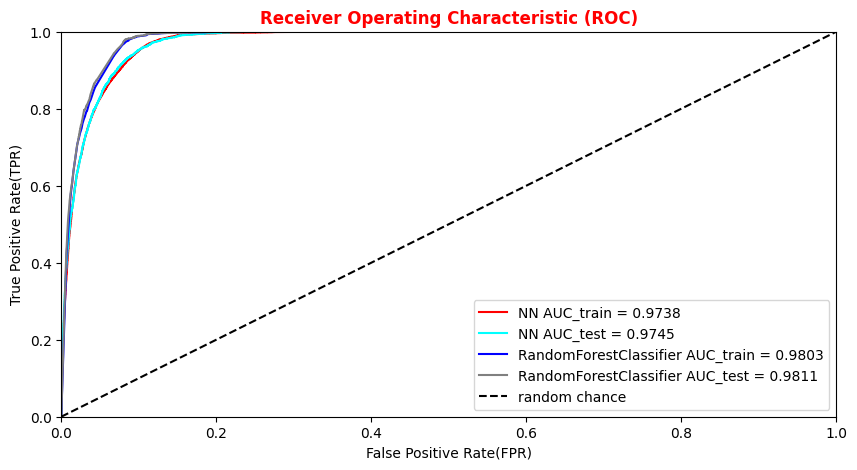

In [54]:
##Superimposition RF and ANN ROC curves
plt.rcParams['figure.figsize'] = (10,5)
plt.plot(fpr_train, tpr_train, color='red', label='NN AUC_train = %.4f' % (roc_auc_train))
plt.plot(fpr, tpr,  color='cyan', label='NN AUC_test = %.4f' % (roc_auc))
#Random Forest 1st method
plt.plot(fpr_train_rf,tpr_train_rf, color='blue', label='RandomForestClassifier AUC_train = %.4f' % (roc_auc_rf_train))
plt.plot(fpr_rf,tpr_rf, color='grey', label='RandomForestClassifier AUC_test = %.4f' % (roc_auc_rf))
#Random Forest 2nd method
#rfc_disp = plot_roc_curve(rfc, X_train_val,Y_train_val,color='brown',ax=ax, sample_weight=w_train )
#rfc_disp = plot_roc_curve(rfc, X_test, Y_test, color='grey',ax=ax, sample_weight=w_test)
#random chance
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='random chance')
plt.xlim([0, 1.0]) #fpr
plt.ylim([0, 1.0]) #tpr
plt.title('Receiver Operating Characteristic (ROC)',fontsize=12,fontweight='bold', color='r')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.legend(loc="lower right")
plt.show()



# Plot physics observables

We can easily plot the quantities (e.g. $m_{jj}$, $\eta_{j}$, $m_{4l}$, $m_{Z_{1}}$,$m_{Z_{2}}$) for those events in the datasets which have the ANN and the RF output scores greater than the chosen decision threshold in order to show that the ML discriminators did learn from physics observables!
<br>
The subsections of this notebook part are:
* **Artificial Neural Network rates fixing an ANN score threshold from data frame**
* **Exercise 2 - Random Forest rates fixing a RF score threshold from data frame**
* **Plot some physical quantities after that the event selection is applied**





In [55]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Define a data frame for low level features
data = df_all.filter(NN_VARS)
X_all   = np.asarray( data.values ).astype(np.float32)
#Use it for evaluating the NN output score for the entire dataset
Y_all = model.predict(X_all)

##Artificial Neural Network rates fixing an ANN score threshold from data frame

Let's fix a cut (looking at the performance of our models in terms of the previous **purity*efficiency** metrics plot) on our test statistic (ANN score and RF score) to select mostly VBF Higgs production signal events! 

In [56]:
# Add the ANN prediction array 'NNoutput'column to the complete dataframe in order 
# keep the information about the ML algorithm prediction for every event in the whole dataset
df_all['NNoutput'] = Y_all
# Selects events with NNoutput > cut (and RFoutput > cut_rf later on)
cut_dnn = 0.6
df_sel   = df_all[(df_all['NNoutput'] >= cut_dnn)]
df_TP    = df_all[(df_all['NNoutput'] >= cut_dnn) & (df_all['isSignal'] == 1)]
df_unsel = df_all[(df_all['NNoutput'] < cut_dnn)]
df_TN    = df_all[(df_all['NNoutput'] < cut_dnn) & (df_all['isSignal'] == 0)]

TP = len(df_TP)
FP = len(df_sel) - TP
TN = len(df_TN)
FN = len(df_unsel) - TN

truepositiverate = float(TP)/(TP+FN)
fakepositiverate = float(FP)/(FP+FN)
print('ANN score cut chosen:%.4f' % cut_dnn)
print("TP rate = %.4f"%truepositiverate)
print("FP rate = %.4f"%fakepositiverate)



ANN score cut chosen:0.6000
TP rate = 0.9483
FP rate = 0.9644


##Exercise 2 - Random Forest rates fixing a RF score threshold from data frame
You can do the same steps for the Random Forest algorithm!

In [57]:
Y_all_rf = randomforest.predict(X_all)
df_all['RFoutput'] = Y_all_rf

cut_rf = 0.6 
df_sel_rf   = df_all[(df_all['RFoutput'] >= cut_rf)]
df_TP_rf    = df_all[(df_all['RFoutput'] >= cut_rf) & (df_all['isSignal'] == 1)]
df_unsel_rf = df_all[(df_all['RFoutput'] < cut_rf)]
df_TN_rf    = df_all[(df_all['RFoutput'] < cut_rf) & (df_all['isSignal'] == 0)]

TP_rf = len(df_TP_rf)
FP_rf = len(df_sel_rf) - TP_rf
TN_rf = len(df_TN_rf)
FN_rf = len(df_unsel_rf) - TN_rf


truepositiverate_rf = float(TP_rf)/(TP_rf+FN_rf)
fakepositiverate_rf = float(FP_rf)/(FP_rf+FN_rf)
print('RF score cut chosen: %.4f' % cut_rf)
print("TP rate = %.4f"%truepositiverate_rf)
print("FP rate = %.4f"%fakepositiverate_rf)



RF score cut chosen: 0.6000
TP rate = 0.9812
FP rate = 0.9874


##Plot some physical quantities after that the event selection is applied

Note that we have not used the *low level features* in the training phase of our models,they behaved as **spectator variables**. We will plot the distribution of events considering their **actual label** (in the legend **signal** and **background**) and the distributions for the two classes that our classifiers have built after having fixed a threshold on their output scores.

**Question to students**: look at the plots and comment on them. Taking into account the physics processes involved, did you expect these distributions?

**Hint**: The datasets are simulated events in which the Higgs boson is produced with a mass of 125 GeV. Therefore, we expect to see one **on-mass-shell** Z boson and another **off-mass-shell** Z boson.

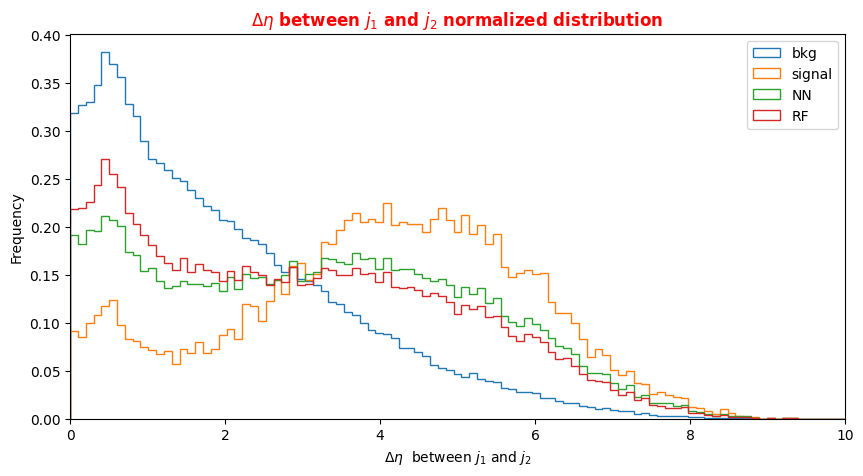

In [58]:
# Plot high level variables for signal, background and NN/RF selected events 

plt.xlabel('$\Delta \eta $  between $j_1$ and $j_2$')
X = np.linspace(0.0,10.,100)
plt.rcParams['figure.figsize'] = (10,5)
# Plot bkg events
df_all['f_deltajj'][(df_all['isSignal'] == 0)].plot.hist( bins=X, label='bkg',histtype='step', density=1 )
# Plot signal events
df_all['f_deltajj'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
# Plot selected events by the ANN
df_sel['f_deltajj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
# Plot selected events by the RF 
df_sel_rf['f_deltajj'].plot.hist(bins=X, label='RF',histtype='step', density=1)
plt.legend(loc='best')
plt.title('$\Delta \eta $ between $j_1$ and $j_2$ normalized distribution',fontsize=12,fontweight='bold', color='r')
plt.xlim(0,10)
plt.show()

(0.0, 1000.0)

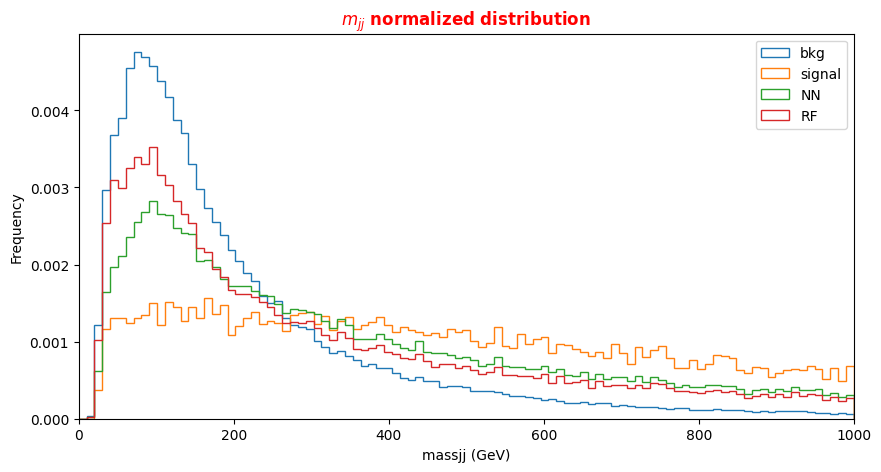

In [59]:

# Plot  dijets mass for signal, background and NN/RF selected events 
plt.xlabel('massjj (GeV)')
X = np.linspace(0.0,1000.,100)
plt.rcParams['figure.figsize'] = (10,5)
df_all['f_massjj'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1 )
df_all['f_massjj'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_massjj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
df_sel_rf['f_massjj'].plot.hist(bins=X, label='RF',histtype='step', density=1)
plt.title('$m_{jj}$ normalized distribution',fontsize=12,fontweight='bold', color='r')
plt.legend(loc='upper right')
plt.xlim(0,1000)

(50.0, 400.0)

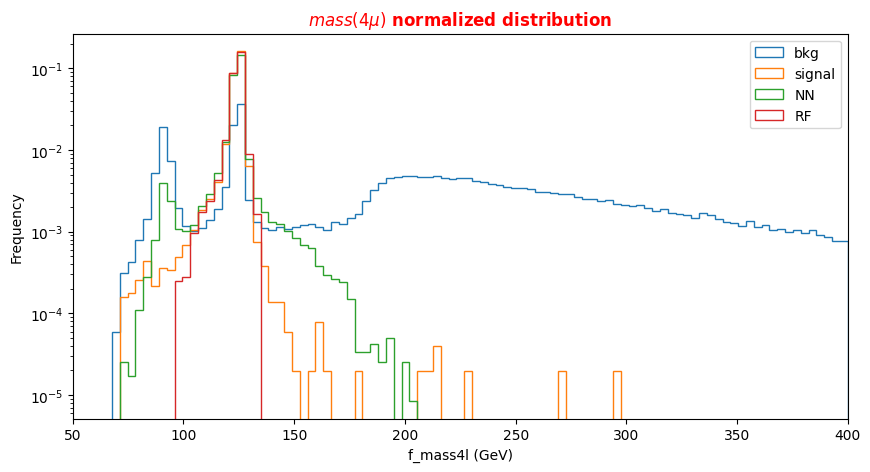

In [60]:

# Plot  dijets mass for signal, background and NN/RF selected events 
plt.xlabel('f_mass4l (GeV)')
X = np.linspace(50, 400, 100)
plt.rcParams['figure.figsize'] = (10,5)
df_all['f_mass4l'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step',log=True, density=1)
df_all['f_mass4l'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step',log=True, density=1)
df_sel['f_mass4l'].plot.hist(bins=X, label='NN',histtype='step', log=True, density=1)
df_sel_rf['f_mass4l'].plot.hist(bins=X, label='RF',histtype='step',log=True, density=1)
plt.title('$mass(4\mu)$ normalized distribution',fontsize=12,fontweight='bold', color='r')
plt.legend(loc='upper right')
plt.xlim(50,400)


(20.0, 150.0)

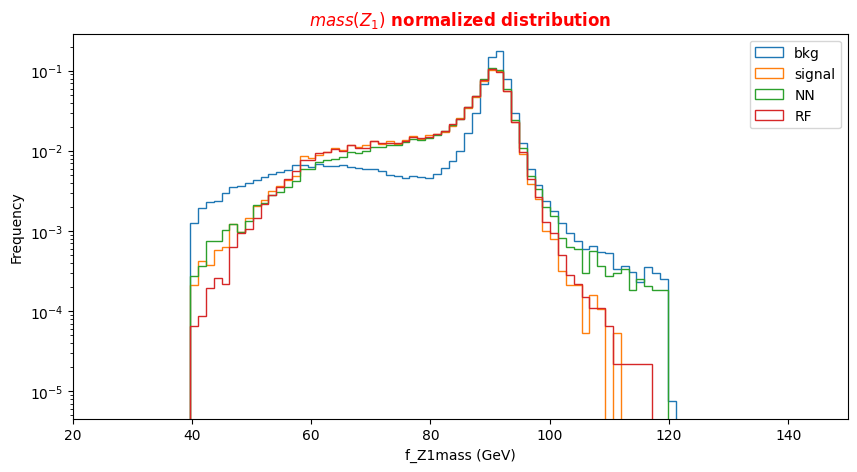

In [61]:

plt.xlabel('f_Z1mass (GeV)')
X = np.linspace(20, 150, 100)
plt.rcParams['figure.figsize'] = (10,5)
df_all['f_Z1mass'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step',log=True ,density=1)
df_all['f_Z1mass'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step',log=True, density=1)
df_sel['f_Z1mass'].plot.hist(bins=X, label='NN',histtype='step', log=True,density=1)
df_sel_rf['f_Z1mass'].plot.hist(bins=X, label='RF',histtype='step',log=True, density=1)
plt.title('$mass(Z_{1})$ normalized distribution',fontsize=12,fontweight='bold', color='r')
plt.legend(loc='upper right')
plt.xlim(20,150)


(0.0, 150.0)

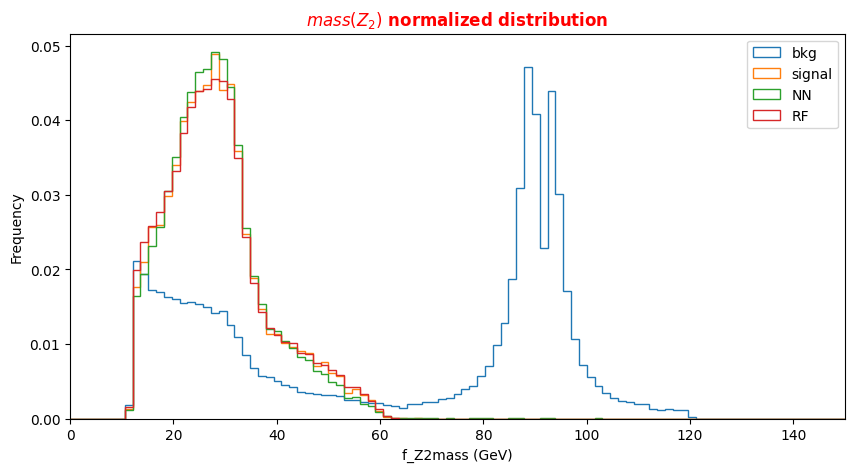

In [62]:
plt.xlabel('f_Z2mass (GeV)')
X = np.linspace(0., 150, 100)
plt.rcParams['figure.figsize'] = (10,5)
df_all['f_Z2mass'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_Z2mass'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_Z2mass'].plot.hist(bins=X, label='NN',histtype='step', density=1)
df_sel_rf['f_Z2mass'].plot.hist(bins=X, label='RF',histtype='step', density=1)
plt.title('$mass(Z_{2})$ normalized distribution',fontsize=12,fontweight='bold', color='r')
plt.legend(loc='upper right')
plt.xlim(0.,150)

Let's do the same for some variables which we have not used during the **training phase**. What can you say about them?

(-5.0, 5.0)

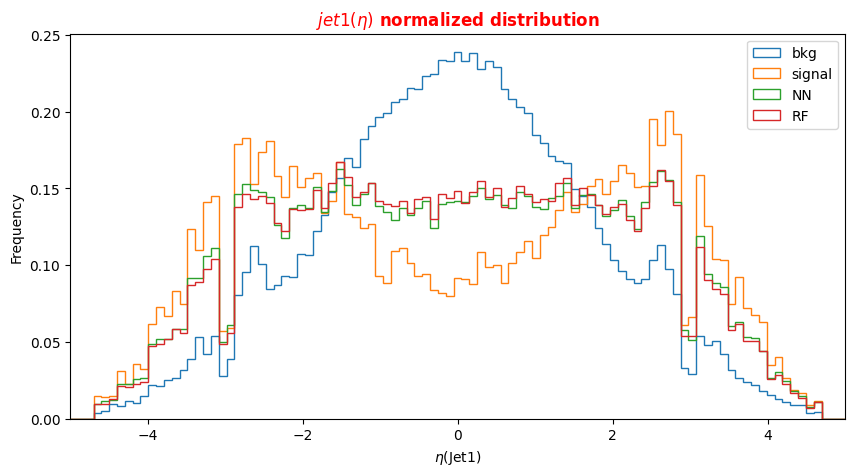

In [63]:
# Plot Jet1 eta for signal, background and NN/RF selected events 
plt.xlabel('$\eta$(Jet1)')
X = np.linspace(-5.,5.,100)
plt.rcParams['figure.figsize'] = (10,5)
df_all['f_jet1_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_jet1_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_jet1_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
df_sel_rf['f_jet1_eta'].plot.hist(bins=X, label='RF',histtype='step', density=1)
plt.legend(loc='upper right')
plt.title('$jet1(\eta)$ normalized distribution',fontsize=12,fontweight='bold', color='r')
plt.xlim(-5,5)

(-5.0, 5.0)

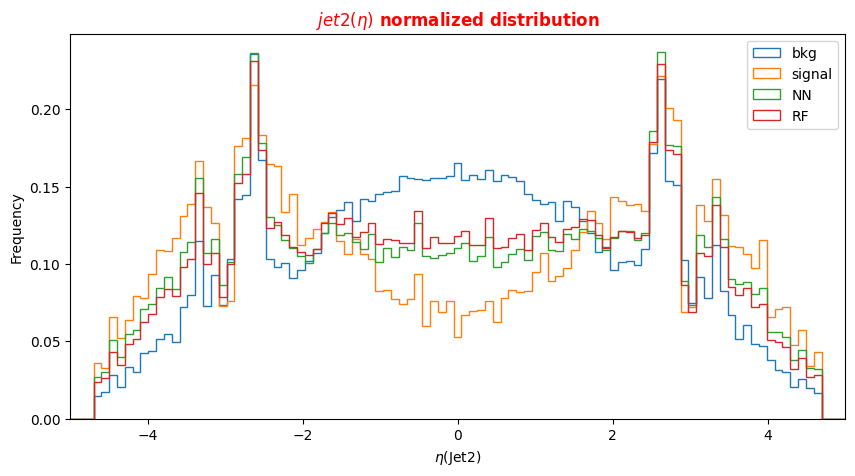

In [64]:
# Plot Jet2 eta for signal, background and NN/RF selected events 
plt.xlabel('$\eta$(Jet2)')
X = np.linspace(-5.,5.,100)
plt.rcParams['figure.figsize'] = (10,5)
df_all['f_jet2_eta'][(df_all['isSignal'] == 0)].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df_all['f_jet2_eta'][(df_all['isSignal'] == 1)].plot.hist(bins=X, label='signal',histtype='step', density=1)
df_sel['f_jet2_eta'].plot.hist(bins=X, label='NN',histtype='step', density=1)
df_sel_rf['f_jet2_eta'].plot.hist(bins=X, label='RF',histtype='step', density=1)
plt.title('$jet2(\eta)$ normalized distribution',fontsize=12,fontweight='bold', color='r')
plt.legend(loc='upper right')
plt.xlim(-5,5)



#Optional Exercise 1 - Change the decay channel

**Question to students:** What happens if you switch to the $4e$ decay channel? You can submit your model (see the ML challenge below) for this physical process as well!

#Optional Exercise 2 - Merge the backgrounds

**Question to students:** Merge the backgrounds used up to now for the training of our ML algorithms together with the ROOT File named **ttH_HToZZ_4L.root**. In this case you will use also the QCD $gg\to t\bar tH \to t\bar t ZZ \to 4\mu (e) + X$ *irreducible* background. Uncomment the correct lines of code to proceed!




In [66]:
!pip install google.colab


/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 72 kB 784 kB/s eta 0:00:01
     |████████████████████████████████| 64 kB 3.1 MB/s  eta 0:00:01
     |████████████████████████████████| 104 kB 41.8 MB/s eta 0:00:01
     |████████████████████████████████| 758 kB 61.2 MB/s eta 0:00:01
     |████████████████████████████████| 8.0 MB 32.1 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 29.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 6.4 MB/s  eta 0:00:01
     |████████████████████████████████| 484 kB 45.4 MB/s eta 0:00:01
     |████████████████████████████████| 245 kB 53.9 MB/s et

In [67]:
### Evaluate performance on an independent sample
# DO NOT CHANGE BELOW!
from google.colab import files


files = {
    "input_hl.csv":"dBHt9vsvKDUkJNt" #high level features
    }
!rm -f *.root
import os 
for file in files.items():
  if not os.path.exists(file[0]):
    b = os.system ( "wget -O %s --no-check-certificate 'https://recascloud.ba.infn.it/index.php/s/%s/download'" % file )
    if b: raise IOError ( "Error in downloading the file %s : (%s)" % file )

filename = {}

df_challenge = {}
#Open the file with dat aset without y_true (only features used for the training of the previous NN model)
filename['input'] = 'input_hl.csv'
df_challenge['input']  = pd.read_csv(filename['input'])
print(df_challenge['input'].shape)
df_challenge['input'].columns= NN_VARS 
X_challenge  = np.asarray( df_challenge['input'].values ).astype(np.float32)
ret = model.predict(X_challenge[:,0:NDIM])
print(ret.shape)
print(ret)
#Convert the y_pred in a dataframe 
df_answer= pd.DataFrame(ret)
df_answer.head()


/usr/local/lib/python3.6/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


(164560, 5)
(164560, 1)
[[1.9761039e-05]
 [2.9914007e-01]
 [1.2778914e-04]
 ...
 [2.5498182e-01]
 [1.7249198e-05]
 [8.3567512e-01]]


,0
0,1.976104e-05
1,2.991401e-01
2,1.277891e-04
3,9.160770e-10
4,4.726612e-01


#Machine Learning challenge

Once you manage to improve the network (random forest) performances, you can submit your results and participate in our ML challenge. The challenge samples are available in this workspace, but the true labels (`isSignal`) are removed so that you can't compute the AUC.

* You can participate as a single participant or as a team
* The winner is the one scoring the best AUC in the challenge samples!
* In the next box, you will find some lines of code for preparing an output csv file, containing your y_predic for this new dataset!
* Choose a meaningful name for your result csv file (i.e. your name, or your team name, the model used for the training phase, and the decay channel - 4$\mu$ or 4$e$ - but avoid to submit `results.csv`)
* Download the csv file and upload it here: https://recascloud.ba.infn.it/index.php/s/CnoZuNrlr3x7uPI
* You can submit multiple results, paying attention to name them accordingly (add the version number, such as `v1`, `v34`, etc.)
* You can use this exercise as a starting point (train over constituents)
* We will consider your best result for the final score.
* The winner will be asked to present the ML architecture!

**Have fun!**


In [ ]:
#Check of the input dataset without y_true
df_challenge['input'].head()

In [ ]:
# Converting the dataframe into a csv file
# Modify the 'answer.csv' string in the line code below and insert your name and the ML model trained (rf or nn)!
# Example: df_answer.to_csv('mario_rossi_rf_4mu.csv')
df_answer.to_csv('answer_2017_trial.csv')
print('Your y_pred has been created! Download it from your Drive directory!\n')
!ls -l

 Upload your results here:
 
 https://recascloud.ba.infn.it/index.php/s/CnoZuNrlr3x7uPI
